In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#
#%cd drive/MyDrive/ML_finance/personal

In [2]:
#%ls

# Dependencies

In [3]:
!pip install arch

import os
import pandas as pd
import pandas_datareader as web
import yfinance as yf
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

from matplotlib.ticker import FuncFormatter

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from numpy.linalg import LinAlgError

from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

# Definitions and Data

In [4]:
# load dataset
#scraping wikipedia to fetch S&P 500 and DJI stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)[0]
SP_tickers = SP_stocks['Symbol'].to_list()

DJI = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
)
DJI_symbols = DJI.Symbol.tolist()

In [5]:
def download_stocks(tickers,start='2014-01-01',end='2018-01-01'):
    return yf.download(tickers, start = start, end = end)

def remove_null(df, cutoff = .99):
    df = df.dropna(axis=1)
    df = df.dropna(thresh=int(df.shape[1]*cutoff))
    return df

def winsorize(df,q=.025):
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):

    train_size = int(len(df)*percentage)
    train_set = df[:train_size]
    test_set = df[train_size:]

    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)

    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)

    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)

    return train, test


def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
    0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        #sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = pd.concat([sort_idx,df0])
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

def clustered_corr_plot(df,include_ticks = True):
    corr = df.corr()

    distance_matrix = get_distance_matrix(corr)
    linkage_matrix = linkage(squareform(distance_matrix), 'single')
    sorted_idx = quasi_diagonalize(linkage_matrix)

    clustergrid = sns.clustermap(distance_matrix,
                             method='single',
                             row_linkage=linkage_matrix,
                             col_linkage=linkage_matrix,
                             center=0);
    plt.close()

    sorted_idx = clustergrid.dendrogram_row.reordered_ind
    sorted_tickers = corr.index[sorted_idx].tolist()
    fig, ax = plt.subplots(figsize=(18, 8))

    #sns.heatmap(corr, center = 0, ax=axes[0])
    #axes[0].set_title('Correlation Matrix')
    #fig.tight_layout()

    clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder

    sns.heatmap(clustered_assets, center = 0, ax=ax)
    ax.set_title('Clustered Correlation')
    if not include_ticks:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout();

    return fig

In [6]:
SP_index = download_stocks('^GSPC')['Adj Close']
DJI_index = download_stocks('^DJI')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
SP_idx_returns = SP_index.pct_change().dropna()
DJI_idx_returns = DJI_index.pct_change().dropna()

In [8]:
SP_data = download_stocks(SP_tickers)['Adj Close']
SP_data.index = pd.to_datetime(SP_data.index)

DJI_data = download_stocks(DJI_symbols)['Adj Close']
DJI_data.index = pd.to_datetime(DJI_data.index)

[*********************100%***********************]  503 of 503 completed


14 Failed downloads:
['CDAY', 'OGN', 'OTIS', 'FOXA', 'GEHC', 'MRNA', 'VICI', 'CTVA', 'FOX', 'CARR', 'DOW', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1388552400, endDate = 1514782800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2014-01-01 -> 2018-01-01)')



[*********************100%***********************]  30 of 30 completed


1 Failed download:
['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1388552400, endDate = 1514782800")


In [9]:
DJI_data = remove_null(DJI_data)
SP_data = remove_null(SP_data)

In [10]:
print(SP_data.isna().sum().sum())
print(DJI_data.isna().sum().sum())

0
0


# Data Processing

In [11]:
#SP_returns = SP_data.pct_change().dropna()
#dji_returns = dji_data.pct_change().dropna()

#SP_log_returns = np.log(SP_data/SP_data.shift(1))[1:]
#dji_log_returns = np.log(dji_data/dji_data.shift(1))[1:]
#
#SP_log_returns = winsorize(SP_log_returns)
#dji_log_returns = winsorize(dji_log_returns)

SP_returns = SP_data.pct_change().dropna()
DJI_returns = DJI_data.pct_change().dropna()

SP_returns = winsorize(SP_returns)
DJI_returns = winsorize(DJI_returns)

In [12]:
#SP_train, SP_test = train_test_split(SP_log_returns)
#dji_train, dji_test = train_test_split(dji_log_returns)

SP_train, SP_test = train_test_split(SP_returns)
DJI_train, DJI_test = train_test_split(DJI_returns)

In [13]:
SP_train_scaled = (SP_train-SP_train.mean())/SP_train.std()
SP_test_scaled = (SP_test-SP_train.mean())/SP_train.std()

DJI_train_scaled = (DJI_train-DJI_train.mean())/DJI_train.std()
DJI_test_scaled = (DJI_test-DJI_train.mean())/DJI_train.std()

In [14]:
print('Statistics for SP-500 train set')
print(f'Average normalized return: {SP_train_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_train_scaled.std().mean()}')
print('\n')
print('Statistics for SP-500 test set')
print(f'Average normalized return: {SP_test_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_test_scaled.std().mean()}')

Statistics for SP-500 train set
Average normalized return: -1.0547530058230964e-19
Average standard deviation: 1.0


Statistics for SP-500 test set
Average normalized return: 0.014682791081148457
Average standard deviation: 0.8280152617905491


In [15]:
print('Statistics for DJI train set')
print(f'Average normalized return: {DJI_train_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_train_scaled.std().mean()}')
print('\n')
print('Statistics for DJI test set')
print(f'Average normalized return: {DJI_test_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_test_scaled.std().mean()}')

Statistics for DJI train set
Average normalized return: -4.8759151536119436e-18
Average standard deviation: 1.0


Statistics for DJI test set
Average normalized return: 0.02868443123901921
Average standard deviation: 0.7780345639918117


# EDA

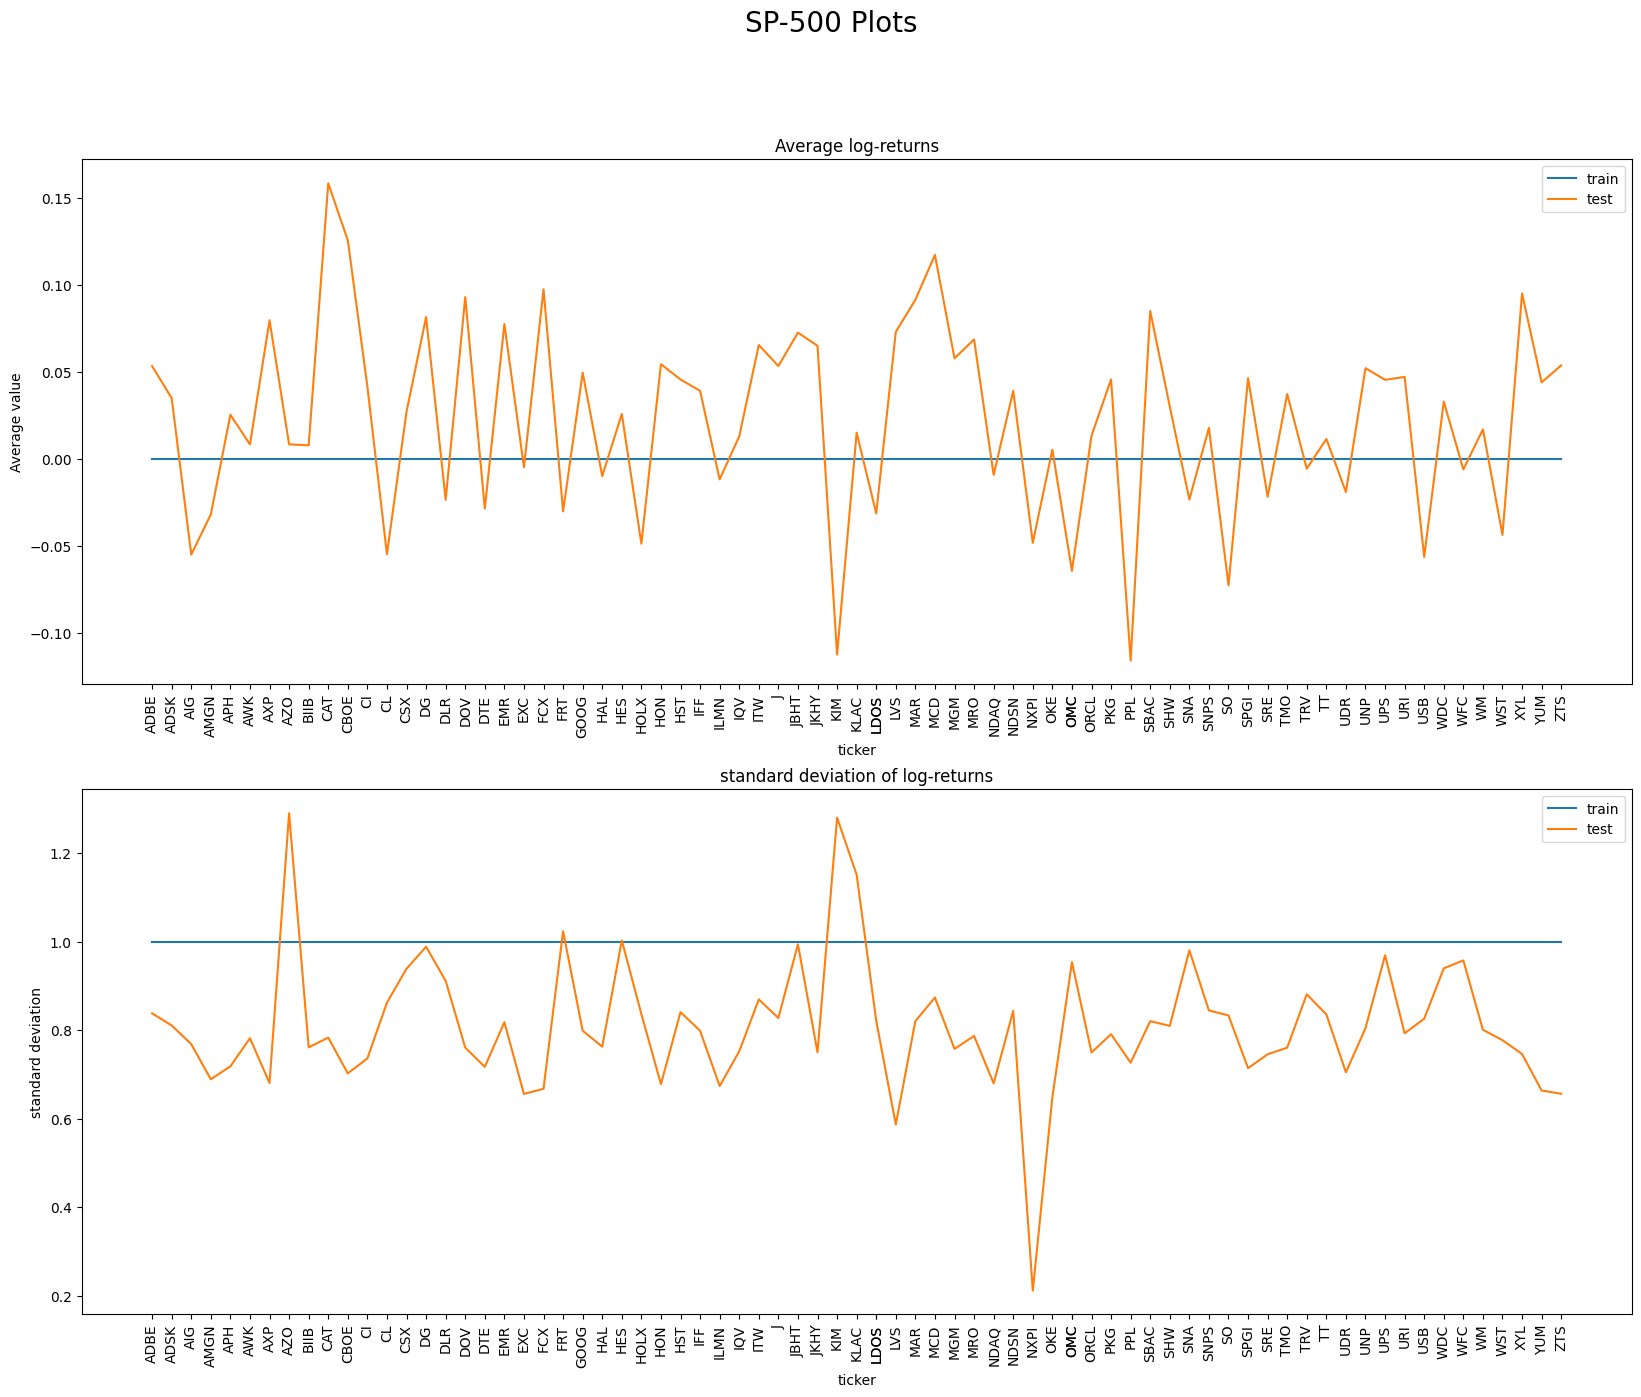

In [16]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

np.random.seed(110)

random_stocks = sorted(np.random.choice(SP_train_scaled.shape[1],75))
random_tickers = list(SP_train_scaled.columns[random_stocks])

SP_train_scaled_sample = SP_train_scaled[random_tickers]
SP_test_scaled_sample = SP_test_scaled[random_tickers]

axes[0].plot(SP_train_scaled_sample.mean(),label='train')
axes[0].plot(SP_test_scaled_sample.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
axes[0].set_xticks(random_tickers)
axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(SP_train_scaled_sample.std(),label='train')
axes[1].plot(SP_test_scaled_sample.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')
axes[1].set_xticks(random_tickers)
axes[1].set_xticklabels(random_tickers,rotation=90);

plt.suptitle('SP-500 Plots',fontsize=20)

plt.show();

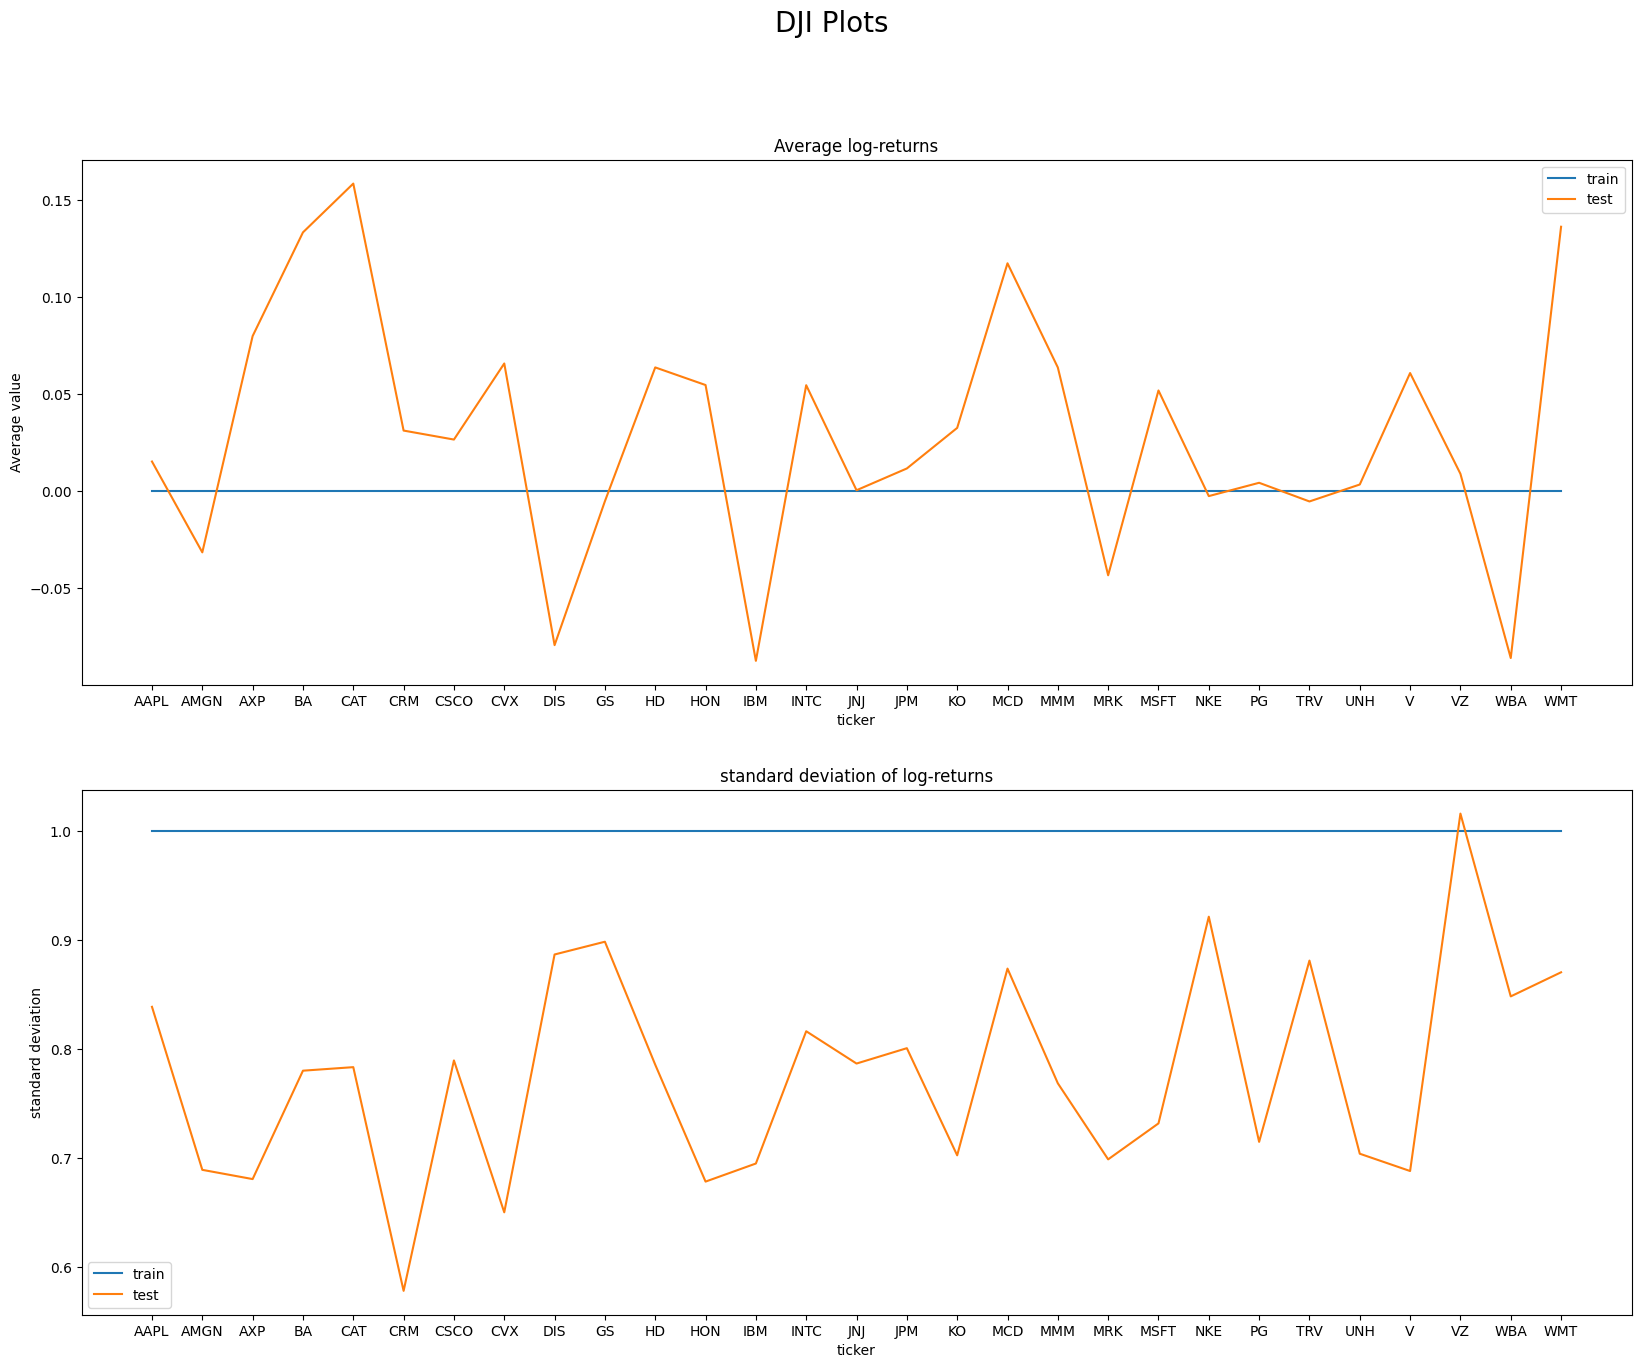

In [17]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

axes[0].plot(DJI_train_scaled.mean(),label='train')
axes[0].plot(DJI_test_scaled.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
#axes[0].set_xticks(random_tickers)
#axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(DJI_train_scaled.std(),label='train')
axes[1].plot(DJI_test_scaled.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')


plt.suptitle('DJI Plots',fontsize=20)

plt.show();

In [18]:
SP_train_cov = SP_train.cov()
SP_test_cov = SP_test.cov()

SP_train_corr = SP_train.corr()
SP_test_corr = SP_test.corr()

DJI_train_cov = DJI_train.cov()
DJI_test_cov = DJI_test.cov()

DJI_train_corr = DJI_train.corr()
DJI_test_corr = DJI_test.corr()

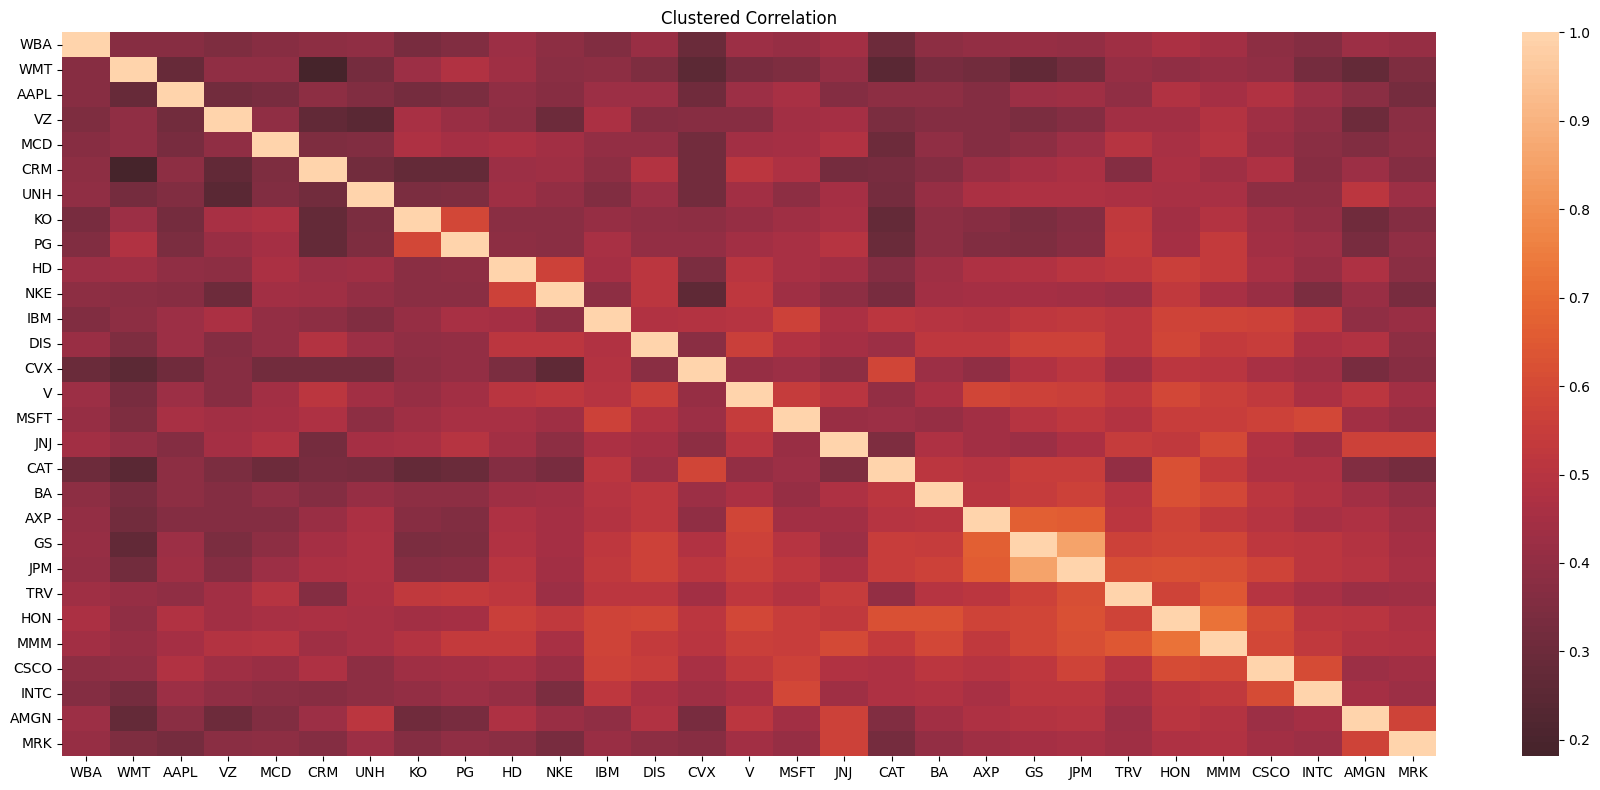

In [19]:
clustered_corr_plot(DJI_train);

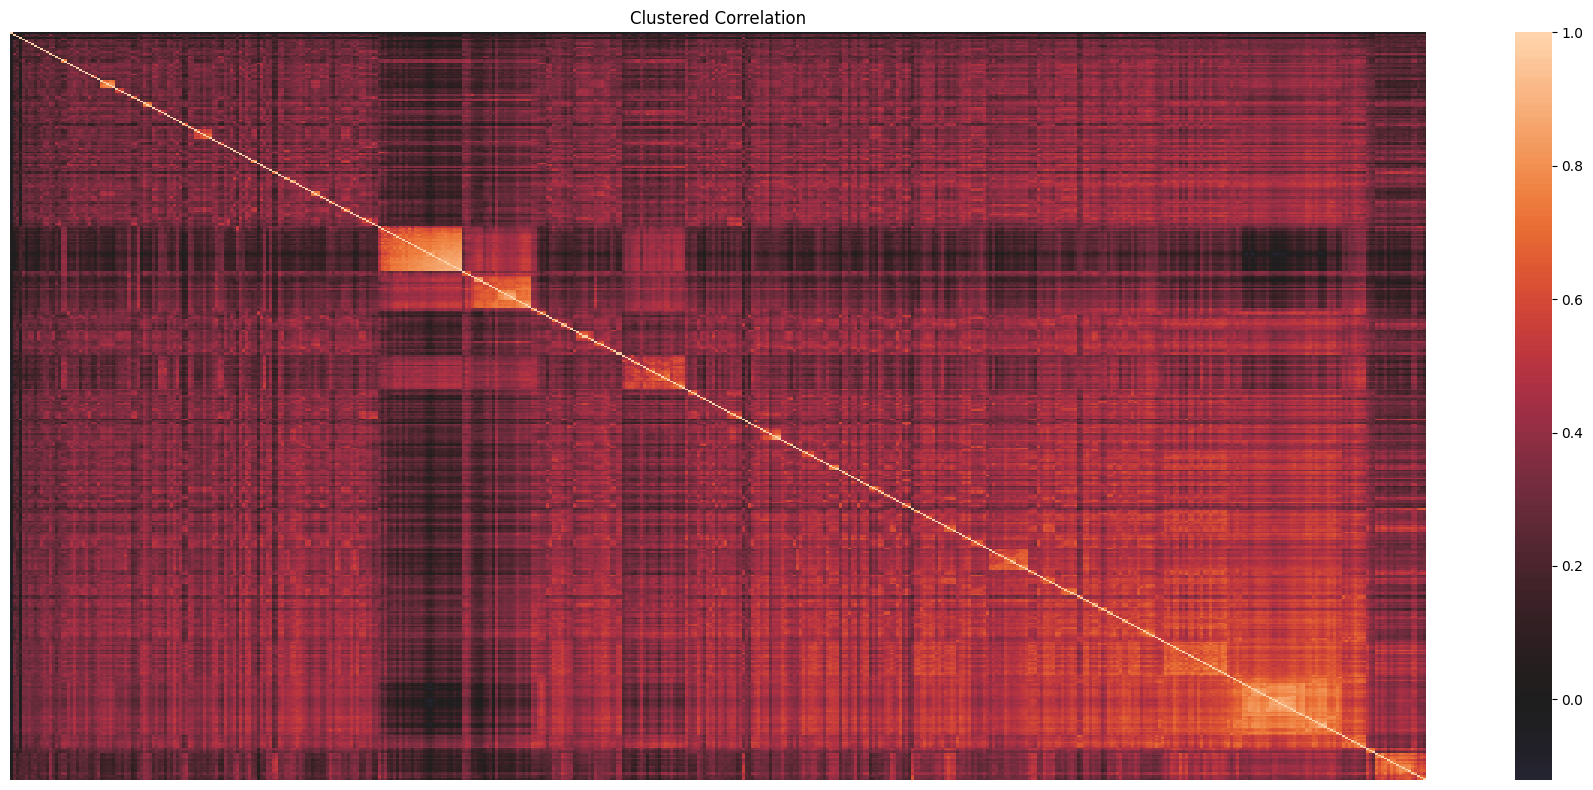

In [20]:
clustered_corr_plot(SP_train,include_ticks=False);

In [21]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(DJI_train_scaled)

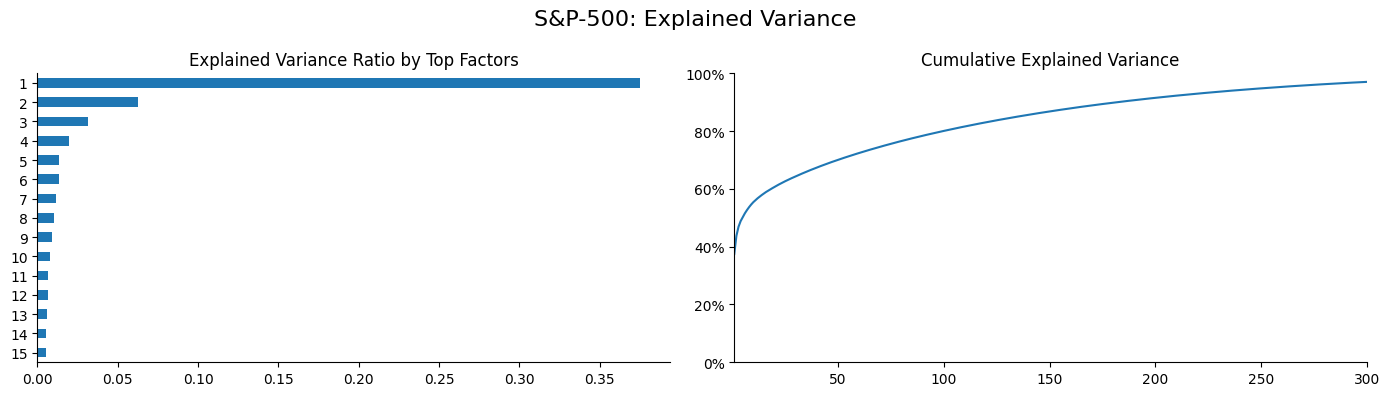

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_SP.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("S&P-500: Explained Variance", size=16)
fig.tight_layout()

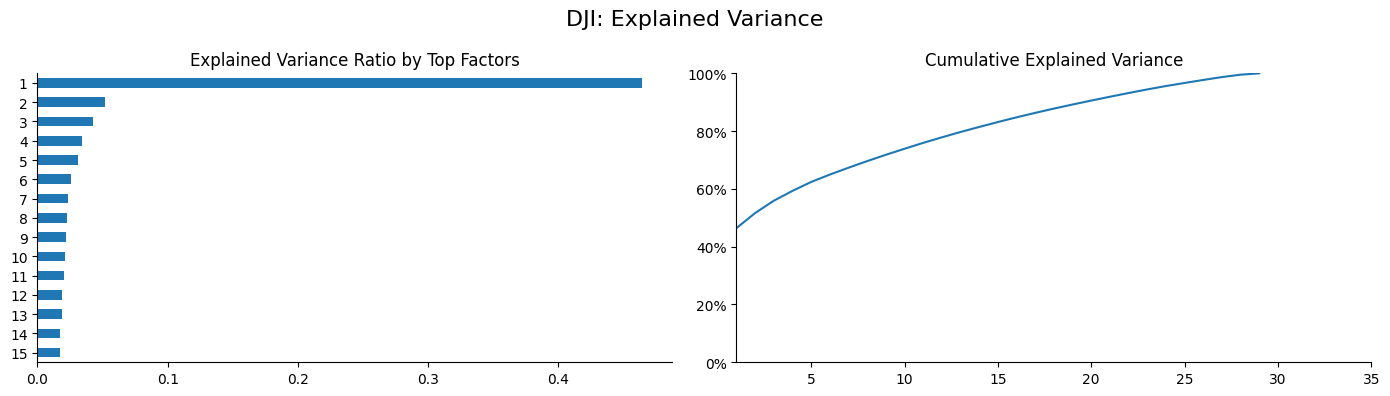

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_DJI.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 35))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("DJI: Explained Variance", size=16)
fig.tight_layout()

In [26]:
DJI_eigvals, DJI_eigvecs = np.linalg.eigh(DJI_train_corr)

DJI_eigvals = DJI_eigvals[::-1]
DJI_eigvecs = DJI_eigvecs[:,::-1]

print(np.allclose(PCA_DJI.explained_variance_ratio_,(DJI_eigvals/np.sum(DJI_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_DJI.components_,DJI_eigvecs)),
            np.eye(DJI_eigvecs.shape[0])))

True
True


In [27]:
SP_eigvals, SP_eigvecs = np.linalg.eigh(SP_train_corr)

SP_eigvals = SP_eigvals[::-1]
SP_eigvecs = SP_eigvecs[:,::-1]

print(np.allclose(PCA_SP.explained_variance_ratio_,(SP_eigvals/np.sum(SP_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_SP.components_,SP_eigvecs)),
            np.eye(SP_eigvecs.shape[0])))

True
True


In [28]:
DJI_evecs_std = (DJI_eigvecs.T/(DJI_train.std().values)).T

np.allclose((DJI_train.dot(DJI_evecs_std)).corr().values,
            np.eye(DJI_evecs_std.shape[0]))

True

In [29]:
SP_evecs_std = (SP_eigvecs.T/(SP_train.std().values)).T

np.allclose((SP_train.dot(SP_evecs_std)).corr().values,
            np.eye(SP_evecs_std.shape[0]))

True

In [30]:
for i in range(DJI_evecs_std.shape[1]):
    DJI_evecs_std[:,i]=DJI_evecs_std[:,i]/np.linalg.norm(DJI_evecs_std[:,i])
    #DJI_evecs_std[:,i] = DJI_evecs_std[:,i]/np.sum(DJI_evecs_std[:,i])

for i in range(SP_evecs_std.shape[1]):
    SP_evecs_std[:,i]=SP_evecs_std[:,i]/np.linalg.norm(SP_evecs_std[:,i])
    #SP_evecs_std[:,i] = SP_evecs_std[:,i]/np.sum(SP_evecs_std[:,i])

In [31]:
DJI_eport_train = DJI_train.dot(DJI_evecs_std)
DJI_eport_test = DJI_test.dot(DJI_evecs_std)

SP_eport_train = SP_train.dot(SP_evecs_std)
SP_eport_test = SP_test.dot(SP_evecs_std)

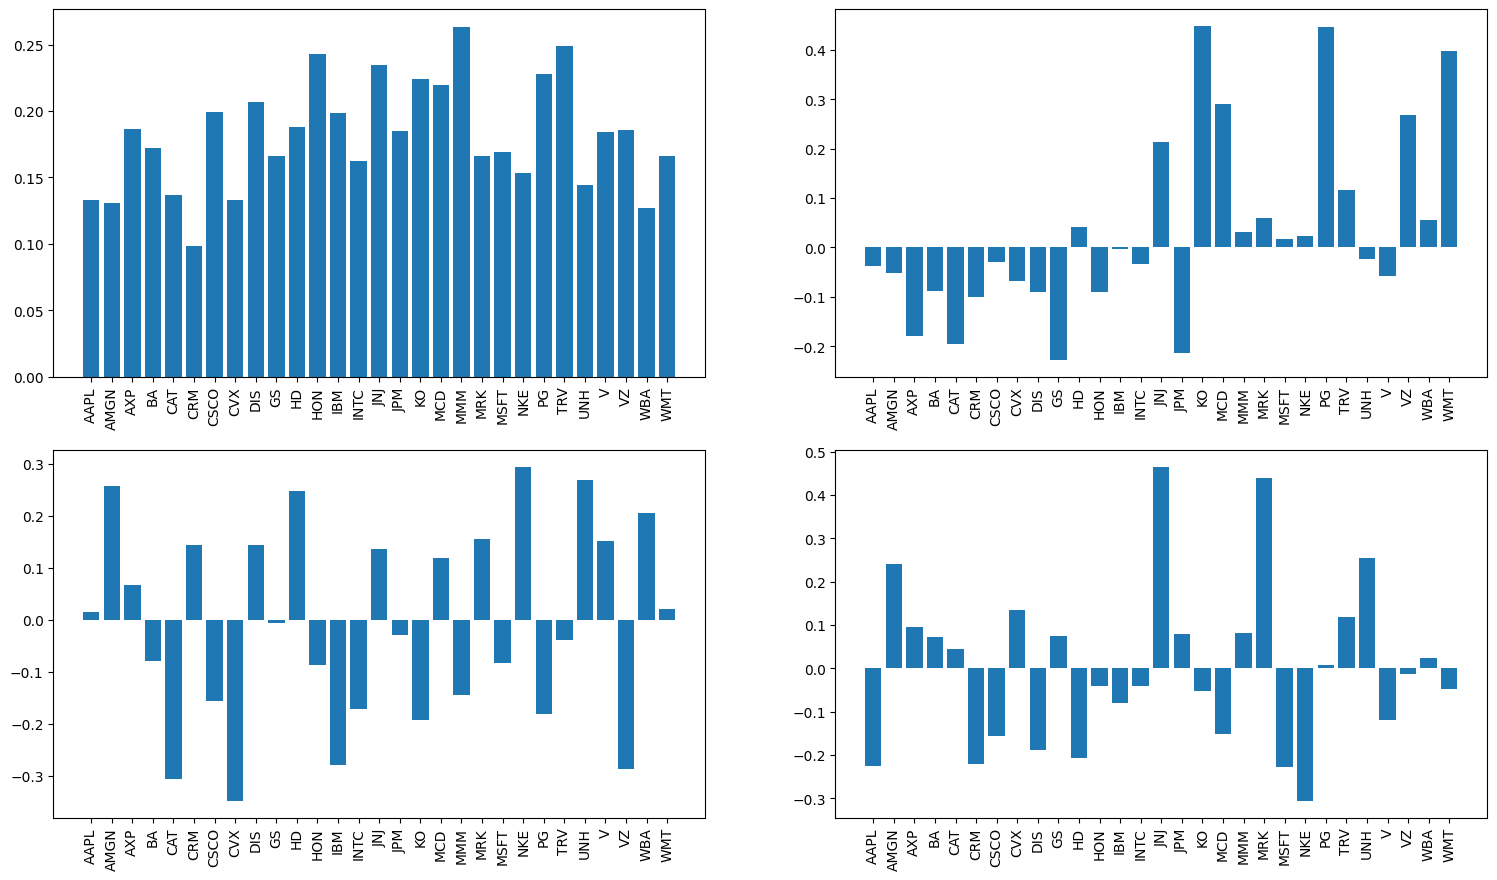

In [32]:
fig, axes = plt.subplots(2,2,sharex=False)

axes[0,0].bar(np.arange(29),
              (DJI_evecs_std[:,0]/np.linalg.norm(DJI_evecs_std[:,0])),
             tick_label=DJI_train.columns);
axes[0,1].bar(np.arange(29),(DJI_evecs_std[:,1]/np.linalg.norm(DJI_evecs_std[:,1])),
             tick_label=DJI_train.columns);
axes[1,0].bar(np.arange(29),(DJI_evecs_std[:,2]/np.linalg.norm(DJI_evecs_std[:,2])),
             tick_label=DJI_train.columns);
axes[1,1].bar(np.arange(29),(DJI_evecs_std[:,3]/np.linalg.norm(DJI_evecs_std[:,3])),
             tick_label=DJI_train.columns);

#axes[0,0].set_xticks(np.arange(29),labels=list(DJI_train.columns),rotation=45);

for i in range(2):
    for j in range(2):
        axes[i,j].set_xticklabels(DJI_train.columns,rotation=90)

fig.set_size_inches(18.5, 10.5)
#axes[0,0].set_xlabel('ticker')
#axes[0,0].set_xticks(np.arange(29));
#axes[0,0].set_xticklabels(DJI_train.columns,rotation=90);

# Sharpe Ratio and Beta

In [ ]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.

    ts_returns are  returns of a single eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year

    annualized_return_pos = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_return_neg = np.power(np.prod(1-ts_returns),(1/n_years))-1

    if annualized_return_pos>annualized_return_neg:
        sign = 1
        annualized_return = annualized_return_pos
    else:
        sign = -1
        annualized_return = annualized_return_neg

    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe, sign

In [ ]:
SP_train_sharpe = np.zeros((SP_eport_train.shape[1],4))

for i, col in enumerate(SP_eport_train.columns):
    SP_train_sharpe[i] = sharpe_ratio(SP_eport_train[col])

df_SP_summary = pd.DataFrame(SP_train_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(SP_train_sharpe.shape[0]))

top_SP_ports = df_SP_summary.sort_values(by='sharpe',ascending=False)[:5]

top_SP_ports_idx = top_SP_ports.index

top_SP_ports

In [ ]:
SP_test_sharpe = np.zeros((SP_eport_test.shape[1],4))

for i, col in enumerate(SP_eport_test.columns):
    SP_test_sharpe[i] = sharpe_ratio(SP_eport_test[col])

df_SP_test_summary = pd.DataFrame(SP_test_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(SP_test_sharpe.shape[0]))

df_SP_test_summary.sort_values(by='sharpe',ascending=False)[:5]

In [ ]:
DJI_train_sharpe = np.zeros((DJI_eport_train.shape[1],4))

for i, col in enumerate(DJI_eport_train.columns):
    DJI_train_sharpe[i] = sharpe_ratio(DJI_eport_train[col])

df_DJI_summary = pd.DataFrame(DJI_train_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(DJI_train_sharpe.shape[0]))

top_DJI_ports = df_DJI_summary.sort_values(by='sharpe',ascending=False)[:5]

top_DJI_ports

In [ ]:
DJI_test_sharpe = np.zeros((DJI_eport_test.shape[1],4))

for i, col in enumerate(DJI_eport_test.columns):
    DJI_test_sharpe[i] = sharpe_ratio(DJI_eport_test[col])

df_DJI_test_summary = pd.DataFrame(DJI_test_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(DJI_test_sharpe.shape[0]))

df_DJI_test_summary.sort_values(by='sharpe',ascending=False)[:5]

In [ ]:
Beta = {}

for i in SP_eport_train.columns:

    Beta['SP','train',i] = (np.cov(SP_eport_train[i].values,
                                  SP_idx_returns.loc[SP_eport_train.index].values)[0,1]
                            /np.var(SP_idx_returns.loc[SP_eport_train.index]))

    Beta['SP','train',i] *= df_SP_summary.loc[i,'sign']

    Beta['SP','test',i] = (np.cov(SP_eport_test[i],
                                 SP_idx_returns.loc[SP_eport_test.index])[0,1]
                           /np.var(SP_idx_returns.loc[SP_eport_test.index]))

    Beta['SP','test',i] *= df_SP_test_summary.loc[i,'sign']

for i in DJI_eport_train.columns:

    Beta['DJI','train',i] = (np.cov(DJI_eport_train[i],
                                   DJI_idx_returns.loc[DJI_eport_train.index])[0,1]
                             /np.var(DJI_idx_returns.loc[DJI_eport_train.index]))

    Beta['DJI','train',i] *= df_DJI_summary.loc[i,'sign']

    Beta['DJI','test',i] = (np.cov(DJI_eport_test[i],
                                  DJI_idx_returns.loc[DJI_eport_test.index])[0,1]
                            /np.var(DJI_idx_returns.loc[DJI_eport_test.index]))

    Beta['DJI','test',i] *= df_DJI_test_summary.loc[i,'sign']

In [ ]:
print('Beta for SP-500 Eigenportfolios:\n')
for i in range(5):
    print(f"Portfolio {i}: train = {round(Beta['SP','train',i],3)}, test = {round(Beta['SP','test',i],3)}")

print('\nBeta for DJI Eigenportfolios:\n')
for i in range(5):
    print(f"Portfolio {i}: train = {round(Beta['DJI','train',i],3)}, test = {round(Beta['DJI','test',i],3)}")

# Dimensionality Reduction

In [ ]:
PCA_SP_dr = PCA(n_components = 'mle').fit(SP_train_scaled)
PCA_DJI_dr = PCA(n_components = 'mle').fit(DJI_train_scaled)

In [ ]:
SP_train_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_train_scaled))
SP_test_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_test_scaled))


DJI_train_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_train_scaled))
DJI_test_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_test_scaled))

In [ ]:
print(np.sqrt(np.linalg.norm(SP_train_reconst-SP_train_scaled.values,
               ord='fro')/np.linalg.norm(SP_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(SP_test_reconst-SP_test_scaled.values,
               ord='fro')/np.linalg.norm(SP_test_scaled.values,
               ord='fro')))

0.6985002280399261
0.8222536792869362


In [ ]:
print(np.sqrt(np.linalg.norm(DJI_train_reconst-DJI_train_scaled.values,
               ord='fro')/np.linalg.norm(DJI_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(DJI_test_reconst-DJI_test_scaled.values,
               ord='fro')/np.linalg.norm(DJI_test_scaled.values,
               ord='fro')))

0.2615700621123662
0.31305714221904685


# Time-Series Predictions

In [33]:
def plot_correlogram(x,
                     lags=None,
                     title=None,
                     vol=False,
                     alpha=.05):

    lags = min(10, int(len(x)/5)) if lags is None else lags

    with sns.axes_style('whitegrid'):

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)

        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])

        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'

        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0], auto_ylims=True, alpha=alpha)
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], auto_ylims=True, alpha=alpha)

        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')

        fig.suptitle(title, fontsize=20)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [42]:
for i in range(5):
    print(f'portfolio {i}: adfuller p-value = {adfuller(DJI_eport_train[i])[1]}')

portfolio 0: adfuller p-value = 0.0
portfolio 1: adfuller p-value = 0.0
portfolio 2: adfuller p-value = 1.3161655213546621e-11
portfolio 3: adfuller p-value = 0.0
portfolio 4: adfuller p-value = 0.0


## ARIMA Models

### S&P-500

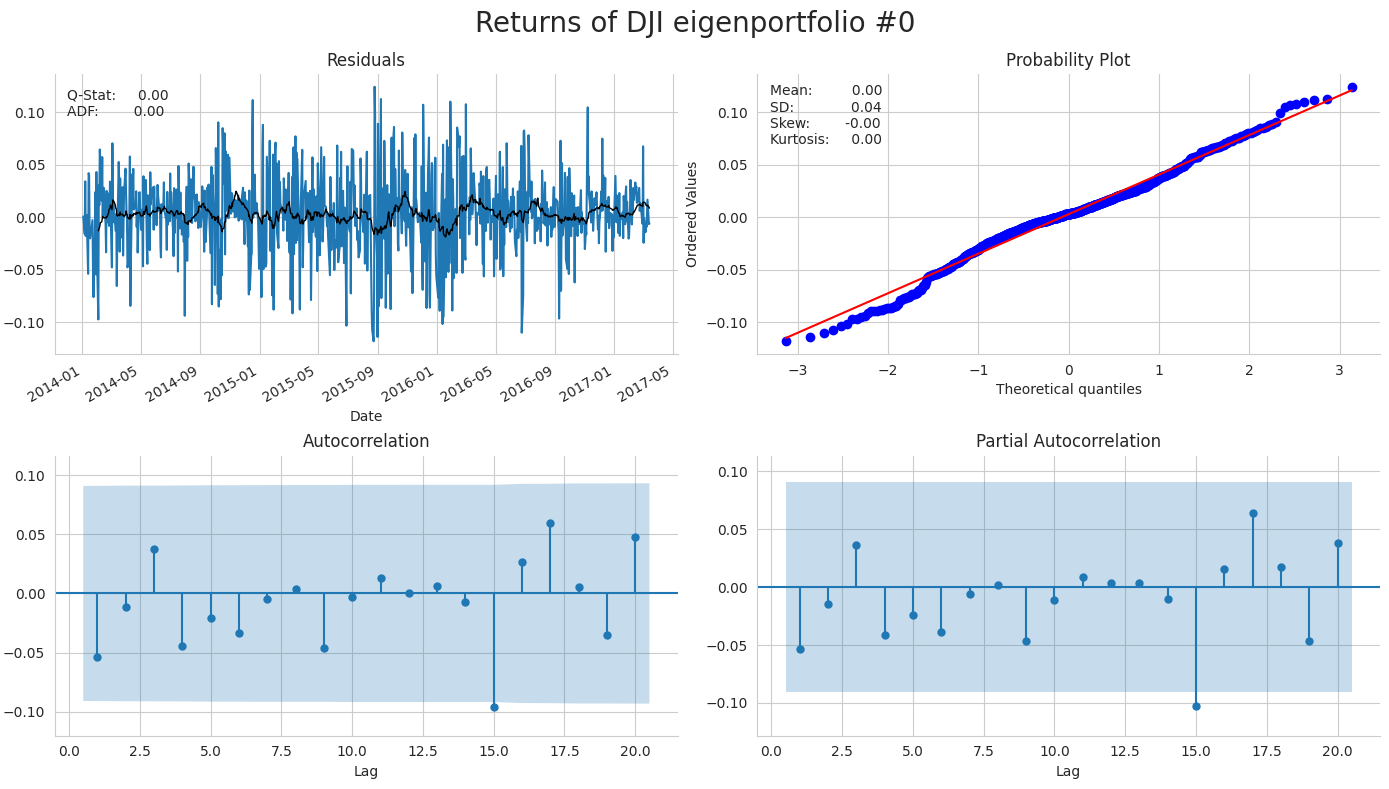

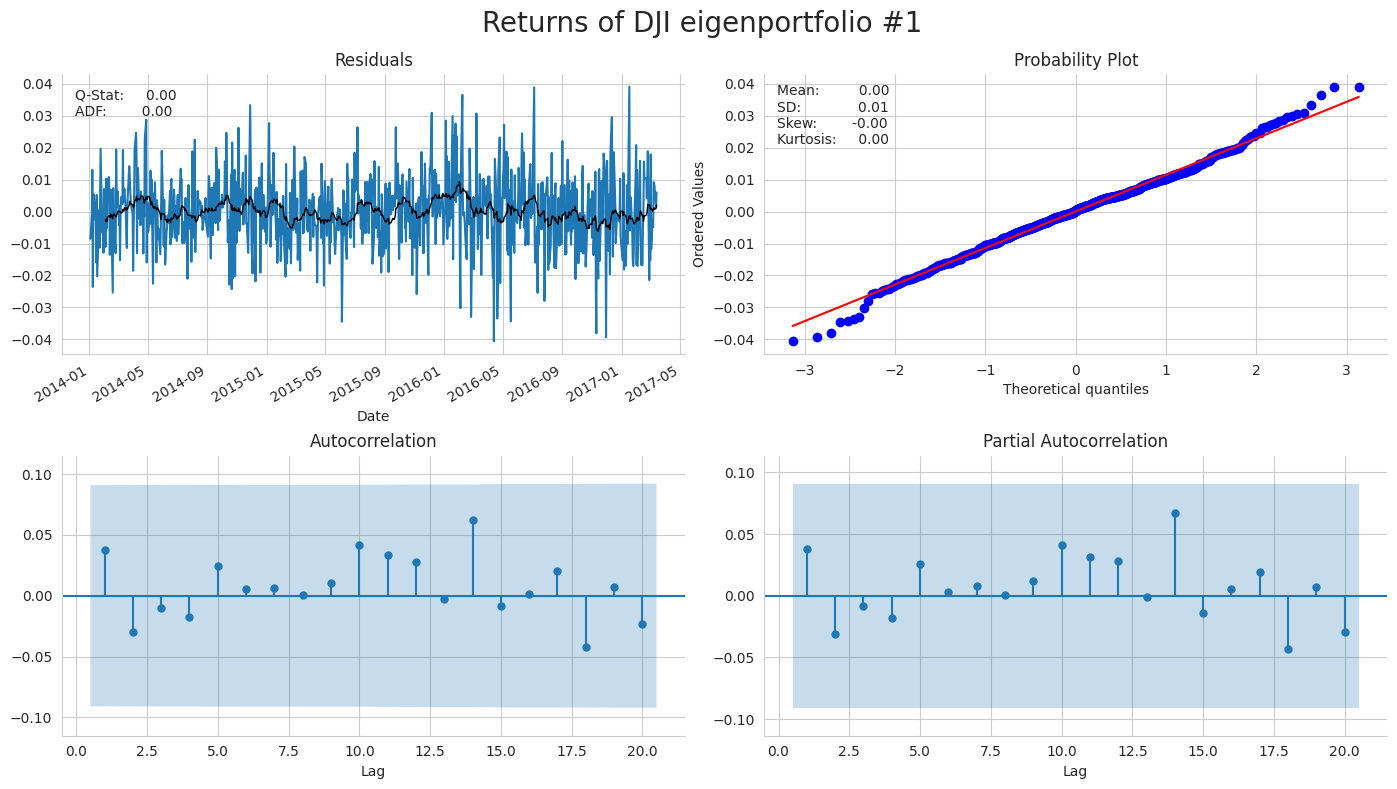

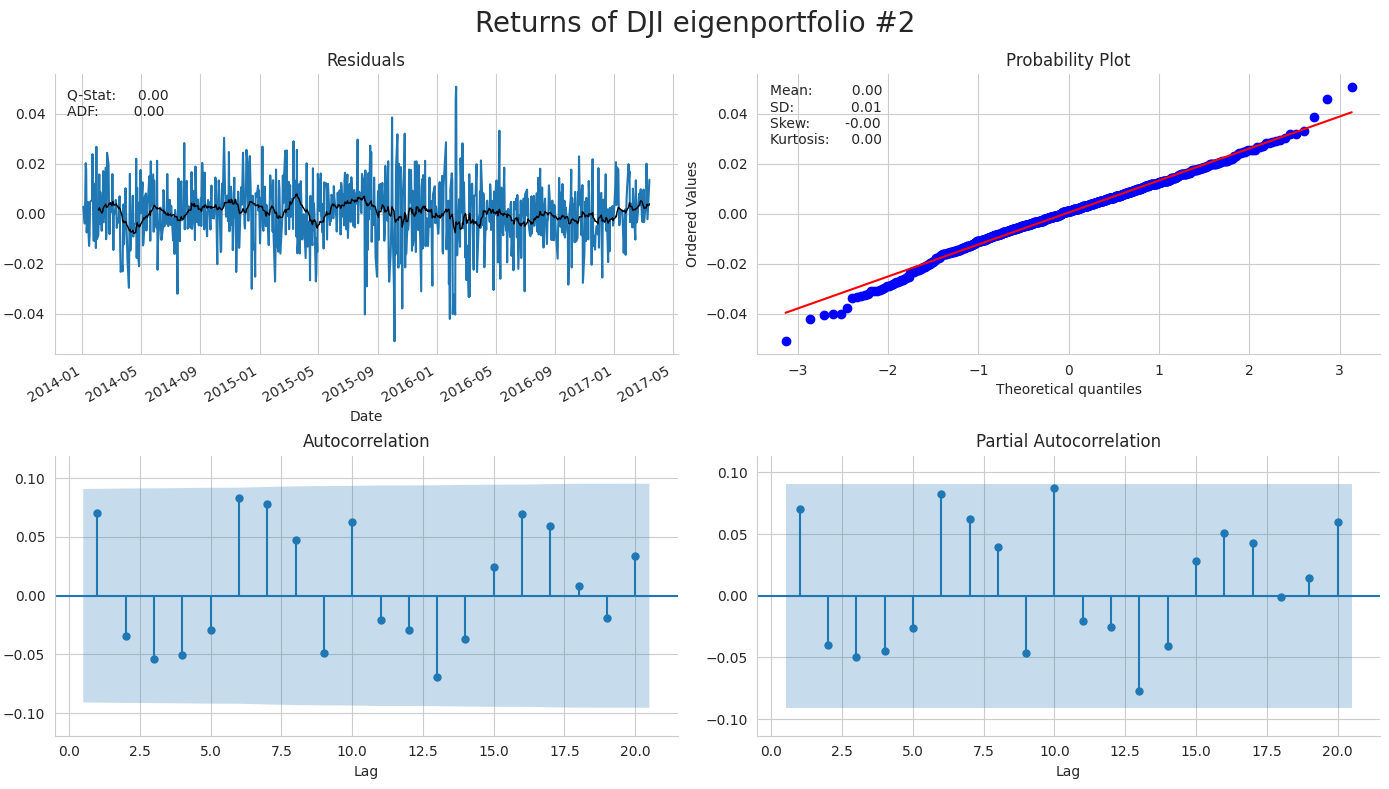

In [ ]:
for i in range(3):
    plot_correlogram(DJI_eport_train[i],lags=20,title=f'Returns of DJI eigenportfolio #{i}',
                    alpha=.01)
#    plot_correlogram((DJI_eport_train[i]-DJI_eport_train[i].mean())**2,
#                     lags=20,title=f'Volatility of DJI eigenportfolio #{i}',
#                    alpha=.01)

In [36]:
train_size = 500
SP_ARIMA_results = {}
time_range = SP_eport_train.shape[0]


for j in range(3):
    SP_portfolio = SP_eport_train[j]
    y_true = SP_portfolio.iloc[train_size:]

    for p in range(5):
        for q in range(5):

            aic, bic = [], []
            rmse = []
            print(f'SP portfolio {j}, ARIMA order = ({p},{q})')

            convergence_error = stationarity_error = 0

            for T in tqdm(range(train_size, time_range)):
                train_set = SP_portfolio.iloc[T-train_size:T]
                try:
                    model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()

                    forecast = model.forecast(steps=1).values[0]

                    rmse.append((y_true[T-train_size]-forecast)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            SP_ARIMA_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

SP portfolio 0, ARIMA order = (0,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:07<00:00, 38.63it/s]


SP portfolio 0, ARIMA order = (0,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:08<00:00, 36.56it/s]


SP portfolio 0, ARIMA order = (0,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 25.65it/s]


SP portfolio 0, ARIMA order = (0,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:18<00:00, 16.50it/s]


SP portfolio 0, ARIMA order = (0,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:23<00:00, 12.71it/s]


SP portfolio 0, ARIMA order = (1,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 30.86it/s]


SP portfolio 0, ARIMA order = (1,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:24<00:00, 12.17it/s]


SP portfolio 0, ARIMA order = (1,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:41<00:00,  7.30it/s]


SP portfolio 0, ARIMA order = (1,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:46<00:00,  6.58it/s]


SP portfolio 0, ARIMA order = (1,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:04<00:00,  4.75it/s]


SP portfolio 0, ARIMA order = (2,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.98it/s]


SP portfolio 0, ARIMA order = (2,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:33<00:00,  9.17it/s]


SP portfolio 0, ARIMA order = (2,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:23<00:00,  3.62it/s]


SP portfolio 0, ARIMA order = (2,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [02:03<00:00,  2.45it/s]


SP portfolio 0, ARIMA order = (2,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [02:41<00:00,  1.88it/s]


SP portfolio 0, ARIMA order = (3,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:23<00:00, 13.12it/s]


SP portfolio 0, ARIMA order = (3,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:20<00:00,  3.78it/s]


SP portfolio 0, ARIMA order = (3,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [02:17<00:00,  2.22it/s]


SP portfolio 0, ARIMA order = (3,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [02:56<00:00,  1.73it/s]


SP portfolio 0, ARIMA order = (3,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:42<00:00,  2.96it/s]


SP portfolio 0, ARIMA order = (4,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:18<00:00, 16.37it/s]


SP portfolio 0, ARIMA order = (4,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:58<00:00,  5.17it/s]


SP portfolio 0, ARIMA order = (4,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:17<00:00,  3.91it/s]


SP portfolio 0, ARIMA order = (4,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:41<00:00,  3.01it/s]


SP portfolio 0, ARIMA order = (4,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [02:04<00:00,  2.44it/s]


SP portfolio 1, ARIMA order = (0,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 31.09it/s]


SP portfolio 1, ARIMA order = (0,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 30.63it/s]


SP portfolio 1, ARIMA order = (0,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:18<00:00, 16.67it/s]


SP portfolio 1, ARIMA order = (0,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:26<00:00, 11.31it/s]


SP portfolio 1, ARIMA order = (0,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:37<00:00,  8.20it/s]


SP portfolio 1, ARIMA order = (1,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 27.35it/s]


SP portfolio 1, ARIMA order = (1,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:20<00:00, 14.80it/s]


SP portfolio 1, ARIMA order = (1,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:30<00:00, 10.12it/s]


SP portfolio 1, ARIMA order = (1,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:54<00:00,  5.56it/s]


SP portfolio 1, ARIMA order = (1,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:20<00:00,  3.77it/s]


SP portfolio 1, ARIMA order = (2,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:10<00:00, 28.07it/s]


SP portfolio 1, ARIMA order = (2,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:31<00:00,  9.78it/s]


SP portfolio 1, ARIMA order = (2,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:48<00:00,  6.31it/s]


SP portfolio 1, ARIMA order = (2,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:12<00:00,  4.21it/s]


SP portfolio 1, ARIMA order = (2,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:33<00:00,  3.25it/s]


SP portfolio 1, ARIMA order = (3,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:15<00:00, 19.41it/s]


SP portfolio 1, ARIMA order = (3,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:40<00:00,  7.51it/s]


SP portfolio 1, ARIMA order = (3,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:10<00:00,  4.32it/s]


SP portfolio 1, ARIMA order = (3,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:28<00:00,  3.44it/s]


SP portfolio 1, ARIMA order = (3,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:43<00:00,  2.94it/s]


SP portfolio 1, ARIMA order = (4,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:20<00:00, 14.56it/s]


SP portfolio 1, ARIMA order = (4,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:02<00:00,  4.88it/s]


SP portfolio 1, ARIMA order = (4,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:21<00:00,  3.73it/s]


SP portfolio 1, ARIMA order = (4,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:31<00:00,  3.32it/s]


SP portfolio 1, ARIMA order = (4,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:59<00:00,  2.55it/s]


SP portfolio 2, ARIMA order = (0,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 27.54it/s]


SP portfolio 2, ARIMA order = (0,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 27.18it/s]


SP portfolio 2, ARIMA order = (0,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:15<00:00, 19.50it/s]


SP portfolio 2, ARIMA order = (0,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:22<00:00, 13.42it/s]


SP portfolio 2, ARIMA order = (0,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:34<00:00,  8.73it/s]


SP portfolio 2, ARIMA order = (1,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:10<00:00, 28.04it/s]


SP portfolio 2, ARIMA order = (1,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:18<00:00, 16.42it/s]


SP portfolio 2, ARIMA order = (1,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:34<00:00,  8.94it/s]


SP portfolio 2, ARIMA order = (1,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:45<00:00,  6.63it/s]


SP portfolio 2, ARIMA order = (1,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:54<00:00,  5.53it/s]


SP portfolio 2, ARIMA order = (2,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 27.23it/s]


SP portfolio 2, ARIMA order = (2,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:37<00:00,  8.07it/s]


SP portfolio 2, ARIMA order = (2,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [12:16<00:00,  2.42s/it]


SP portfolio 2, ARIMA order = (2,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:17<00:00,  3.94it/s]


SP portfolio 2, ARIMA order = (2,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:27<00:00,  3.46it/s]


SP portfolio 2, ARIMA order = (3,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:16<00:00, 17.92it/s]


SP portfolio 2, ARIMA order = (3,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:30<00:00,  9.88it/s]


SP portfolio 2, ARIMA order = (3,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:55<00:00,  5.46it/s]


SP portfolio 2, ARIMA order = (3,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [10:09<00:00,  2.00s/it]


SP portfolio 2, ARIMA order = (3,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:43<00:00,  2.94it/s]


SP portfolio 2, ARIMA order = (4,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:18<00:00, 16.88it/s]


SP portfolio 2, ARIMA order = (4,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:27<00:00, 11.17it/s]


SP portfolio 2, ARIMA order = (4,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [16:02<00:00,  3.17s/it]


SP portfolio 2, ARIMA order = (4,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:32<00:00,  3.27it/s]


SP portfolio 2, ARIMA order = (4,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [03:36<00:00,  1.41it/s]


In [37]:
df_SP_arima_results = pd.DataFrame(SP_ARIMA_results).T
df_SP_arima_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
df_SP_arima_results.index.names = ['i','p', 'q']
df_SP_arima_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75 entries, (0, 0, 0) to (2, 4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          75 non-null     float64
 1   AIC           75 non-null     float64
 2   BIC           75 non-null     float64
 3   convergence   75 non-null     float64
 4   stationarity  75 non-null     float64
dtypes: float64(5)
memory usage: 3.8 KB


In [38]:
os.makedirs('./results', exist_ok=True)
df_SP_arima_results.to_csv('./results/SP_arima_results.csv')

In [39]:
SP_best_arima = []

for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(5):
        for q in range(5):
            bic_tmp = df_SP_arima_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
    SP_best_arima.append((i,p_best,q_best))

In [46]:
SP_best_arima

[(0, 0, 0), (1, 0, 0), (2, 0, 0)]

### DJI

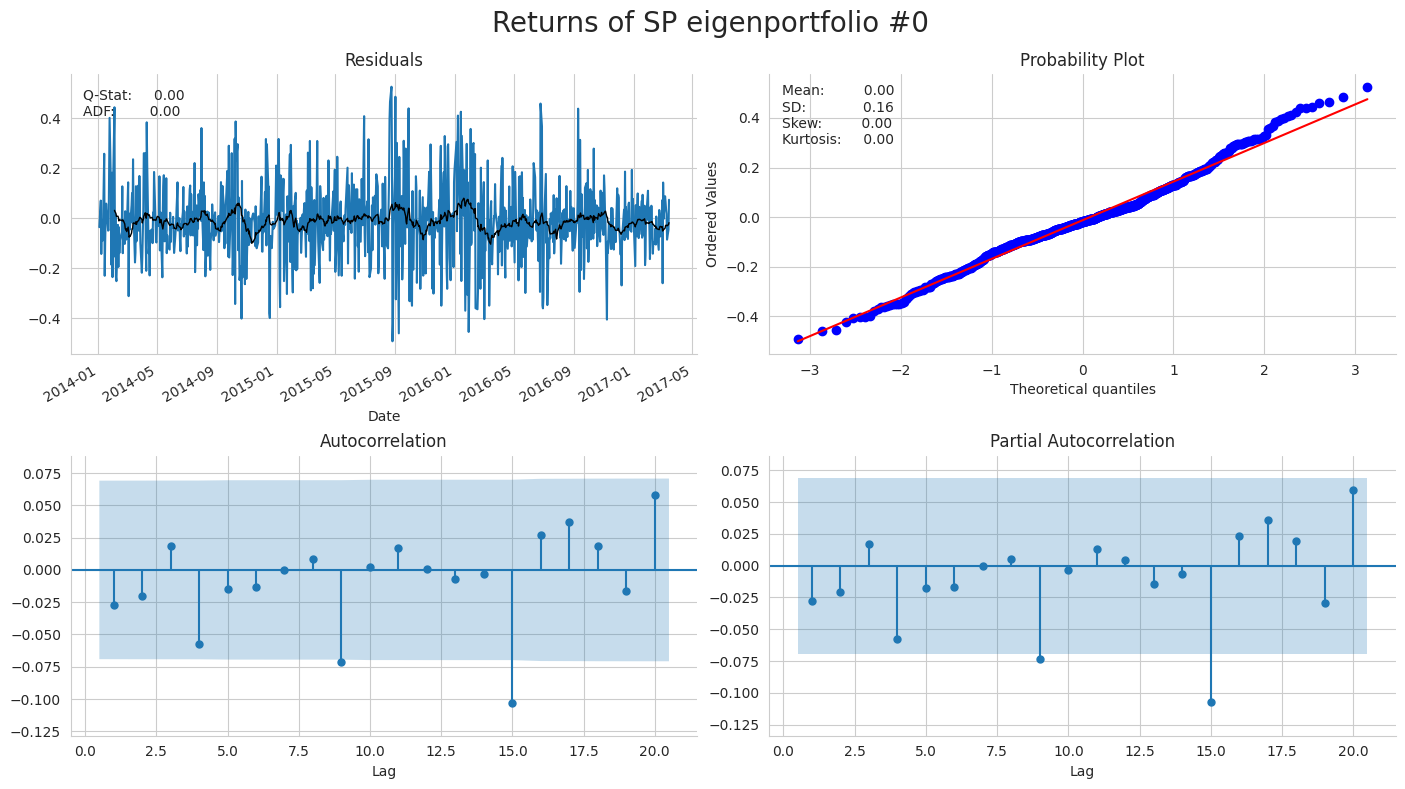

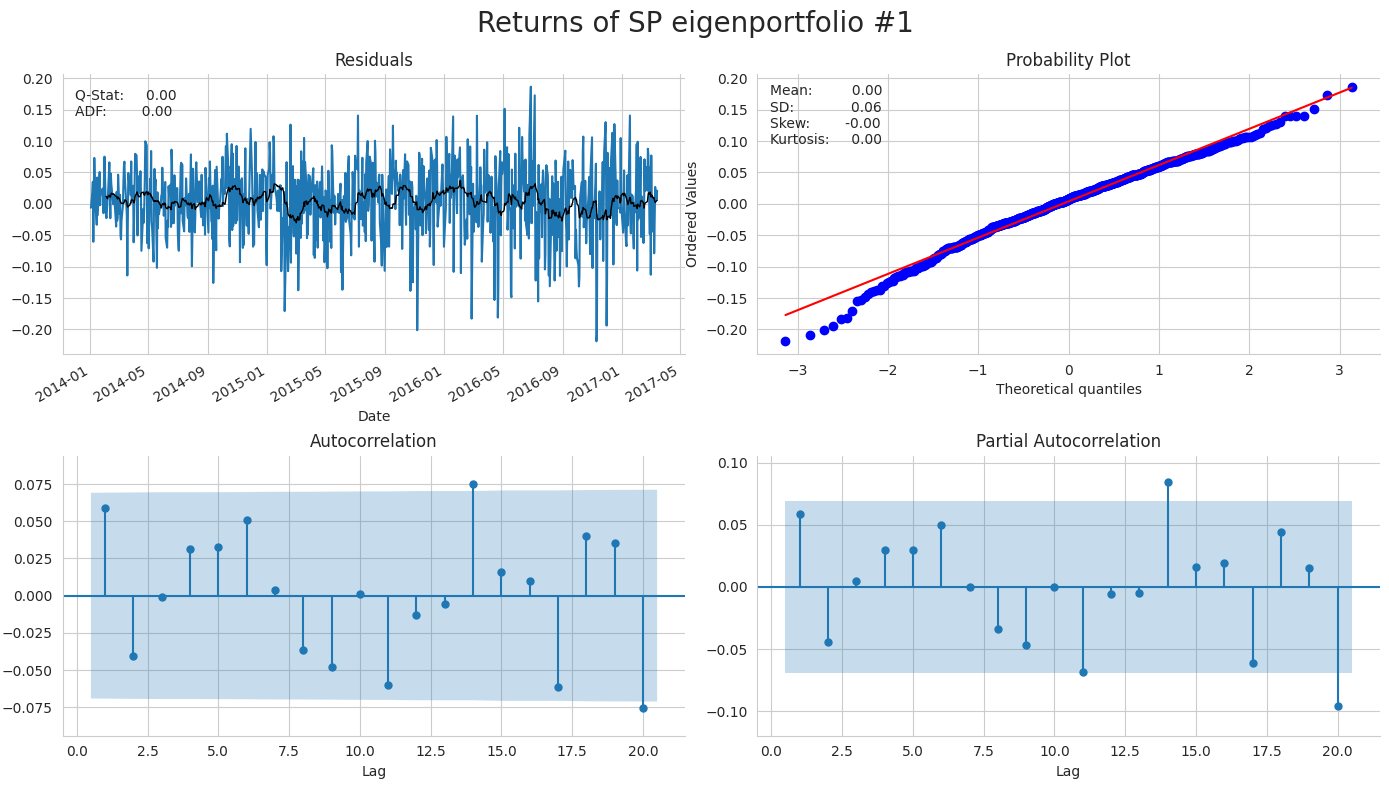

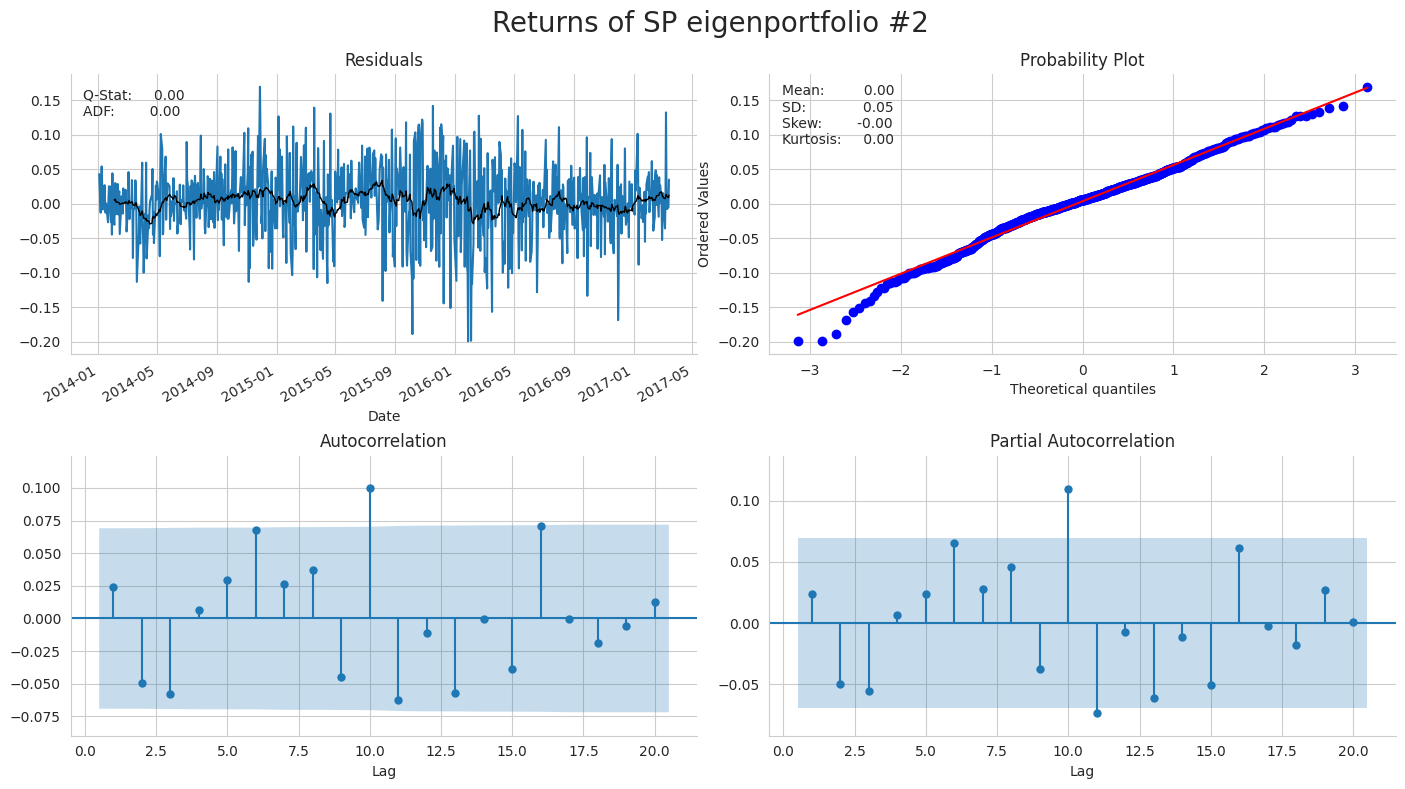

In [ ]:
for i in range(3):
    plot_correlogram(SP_eport_train[i],lags=20,title=f'Returns of SP eigenportfolio #{i}')
#    plot_correlogram((SP_eport_train[i]-DJI_eport_train[i].mean())**2,
#                     lags=20,title=f'Volatility of SP eigenportfolio #{i}')

In [40]:
train_size = 500
DJI_ARIMA_results = {}
time_range = DJI_eport_train.shape[0]


for j in range(3):
    DJI_portfolio = DJI_eport_train[j]
    y_true = DJI_portfolio.iloc[train_size:]

    for p in range(5):
        for q in range(5):

            aic, bic = [], []
            rmse = []
            print(f'DJI portfolio {j}, ARIMA order = ({p},{q})')

            convergence_error = stationarity_error = 0

            for T in tqdm(range(train_size, time_range)):
                train_set = DJI_portfolio.iloc[T-train_size:T]
                try:
                    model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()

                    forecast = model.forecast(steps=1).values[0]

                    rmse.append((y_true[T-train_size]-forecast)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            DJI_ARIMA_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

DJI portfolio 0, ARIMA order = (0,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:08<00:00, 36.55it/s]


DJI portfolio 0, ARIMA order = (0,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:10<00:00, 29.53it/s]


DJI portfolio 0, ARIMA order = (0,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:14<00:00, 20.42it/s]


DJI portfolio 0, ARIMA order = (0,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:24<00:00, 12.62it/s]


DJI portfolio 0, ARIMA order = (0,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:33<00:00,  8.98it/s]


DJI portfolio 0, ARIMA order = (1,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:10<00:00, 28.08it/s]


DJI portfolio 0, ARIMA order = (1,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:17<00:00, 17.56it/s]


DJI portfolio 0, ARIMA order = (1,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:36<00:00,  8.44it/s]


DJI portfolio 0, ARIMA order = (1,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:47<00:00,  6.41it/s]


DJI portfolio 0, ARIMA order = (1,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:04<00:00,  4.71it/s]


DJI portfolio 0, ARIMA order = (2,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 25.65it/s]


DJI portfolio 0, ARIMA order = (2,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:28<00:00, 10.62it/s]


DJI portfolio 0, ARIMA order = (2,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:45<00:00,  6.71it/s]


DJI portfolio 0, ARIMA order = (2,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:04<00:00,  4.71it/s]


DJI portfolio 0, ARIMA order = (2,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:15<00:00,  4.04it/s]


DJI portfolio 0, ARIMA order = (3,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:14<00:00, 20.71it/s]


DJI portfolio 0, ARIMA order = (3,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:25<00:00, 11.84it/s]


DJI portfolio 0, ARIMA order = (3,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:00<00:00,  5.04it/s]


DJI portfolio 0, ARIMA order = (3,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:19<00:00,  3.83it/s]


DJI portfolio 0, ARIMA order = (3,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:30<00:00,  3.36it/s]


DJI portfolio 0, ARIMA order = (4,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:20<00:00, 14.78it/s]


DJI portfolio 0, ARIMA order = (4,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:33<00:00,  9.20it/s]


DJI portfolio 0, ARIMA order = (4,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:10<00:00,  4.34it/s]


DJI portfolio 0, ARIMA order = (4,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:24<00:00,  3.62it/s]


DJI portfolio 0, ARIMA order = (4,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:47<00:00,  2.84it/s]


DJI portfolio 1, ARIMA order = (0,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 25.83it/s]


DJI portfolio 1, ARIMA order = (0,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:13<00:00, 21.84it/s]


DJI portfolio 1, ARIMA order = (0,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:18<00:00, 16.20it/s]


DJI portfolio 1, ARIMA order = (0,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:21<00:00, 14.31it/s]


DJI portfolio 1, ARIMA order = (0,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:25<00:00, 11.74it/s]


DJI portfolio 1, ARIMA order = (1,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 26.66it/s]


DJI portfolio 1, ARIMA order = (1,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:20<00:00, 14.61it/s]


DJI portfolio 1, ARIMA order = (1,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:29<00:00, 10.33it/s]


DJI portfolio 1, ARIMA order = (1,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:30<00:00, 10.02it/s]


DJI portfolio 1, ARIMA order = (1,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:38<00:00,  7.87it/s]


DJI portfolio 1, ARIMA order = (2,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:16<00:00, 18.71it/s]


DJI portfolio 1, ARIMA order = (2,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:24<00:00, 12.26it/s]


DJI portfolio 1, ARIMA order = (2,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:30<00:00,  9.91it/s]


DJI portfolio 1, ARIMA order = (2,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:36<00:00,  8.35it/s]


DJI portfolio 1, ARIMA order = (2,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:42<00:00,  7.16it/s]


DJI portfolio 1, ARIMA order = (3,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:21<00:00, 14.30it/s]


DJI portfolio 1, ARIMA order = (3,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:26<00:00, 11.51it/s]


DJI portfolio 1, ARIMA order = (3,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:42<00:00,  7.16it/s]


DJI portfolio 1, ARIMA order = (3,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:47<00:00,  6.40it/s]


DJI portfolio 1, ARIMA order = (3,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:57<00:00,  5.29it/s]


DJI portfolio 1, ARIMA order = (4,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:26<00:00, 11.34it/s]


DJI portfolio 1, ARIMA order = (4,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:29<00:00, 10.23it/s]


DJI portfolio 1, ARIMA order = (4,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:57<00:00,  5.33it/s]


DJI portfolio 1, ARIMA order = (4,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:53<00:00,  5.71it/s]


DJI portfolio 1, ARIMA order = (4,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:01<00:00,  4.98it/s]


DJI portfolio 2, ARIMA order = (0,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:12<00:00, 24.88it/s]


DJI portfolio 2, ARIMA order = (0,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 25.45it/s]


DJI portfolio 2, ARIMA order = (0,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:15<00:00, 19.31it/s]


DJI portfolio 2, ARIMA order = (0,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:22<00:00, 13.36it/s]


DJI portfolio 2, ARIMA order = (0,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:41<00:00,  7.26it/s]


DJI portfolio 2, ARIMA order = (1,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:11<00:00, 27.62it/s]


DJI portfolio 2, ARIMA order = (1,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:16<00:00, 18.26it/s]


DJI portfolio 2, ARIMA order = (1,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:36<00:00,  8.29it/s]


DJI portfolio 2, ARIMA order = (1,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:32<00:00,  9.37it/s]


DJI portfolio 2, ARIMA order = (1,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:56<00:00,  5.42it/s]


DJI portfolio 2, ARIMA order = (2,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:17<00:00, 17.35it/s]


DJI portfolio 2, ARIMA order = (2,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:41<00:00,  7.35it/s]


DJI portfolio 2, ARIMA order = (2,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:42<00:00,  7.10it/s]


DJI portfolio 2, ARIMA order = (2,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:59<00:00,  5.10it/s]


DJI portfolio 2, ARIMA order = (2,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:15<00:00,  4.03it/s]


DJI portfolio 2, ARIMA order = (3,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:19<00:00, 15.21it/s]


DJI portfolio 2, ARIMA order = (3,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:22<00:00, 13.23it/s]


DJI portfolio 2, ARIMA order = (3,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:12<00:00,  4.21it/s]


DJI portfolio 2, ARIMA order = (3,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:24<00:00,  3.61it/s]


DJI portfolio 2, ARIMA order = (3,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:31<00:00,  3.32it/s]


DJI portfolio 2, ARIMA order = (4,0)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:21<00:00, 13.98it/s]


DJI portfolio 2, ARIMA order = (4,1)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [00:29<00:00, 10.29it/s]


DJI portfolio 2, ARIMA order = (4,2)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:17<00:00,  3.92it/s]


DJI portfolio 2, ARIMA order = (4,3)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:35<00:00,  3.18it/s]


DJI portfolio 2, ARIMA order = (4,4)


100%|████████████████████████████████████████████████████████████████████████████| 304/304 [01:42<00:00,  2.95it/s]


In [41]:
df_DJI_ARIMA_results = pd.DataFrame(DJI_ARIMA_results).T
df_DJI_ARIMA_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
df_DJI_ARIMA_results.index.names = ['i','p', 'q']
df_DJI_ARIMA_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75 entries, (0, 0, 0) to (2, 4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          75 non-null     float64
 1   AIC           75 non-null     float64
 2   BIC           75 non-null     float64
 3   convergence   75 non-null     float64
 4   stationarity  75 non-null     float64
dtypes: float64(5)
memory usage: 3.8 KB


In [42]:
df_DJI_ARIMA_results.to_csv('./results/DJI_ARIMA_results.csv')

In [44]:
DJI_best_arima = []


for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(5):
        for q in range(5):
            bic_tmp = df_DJI_ARIMA_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
    DJI_best_arima.append((i,p_best,q_best))

In [49]:
DJI_best_arima

[(0, 0, 0), (1, 0, 0), (2, 0, 0)]

## Garch Models

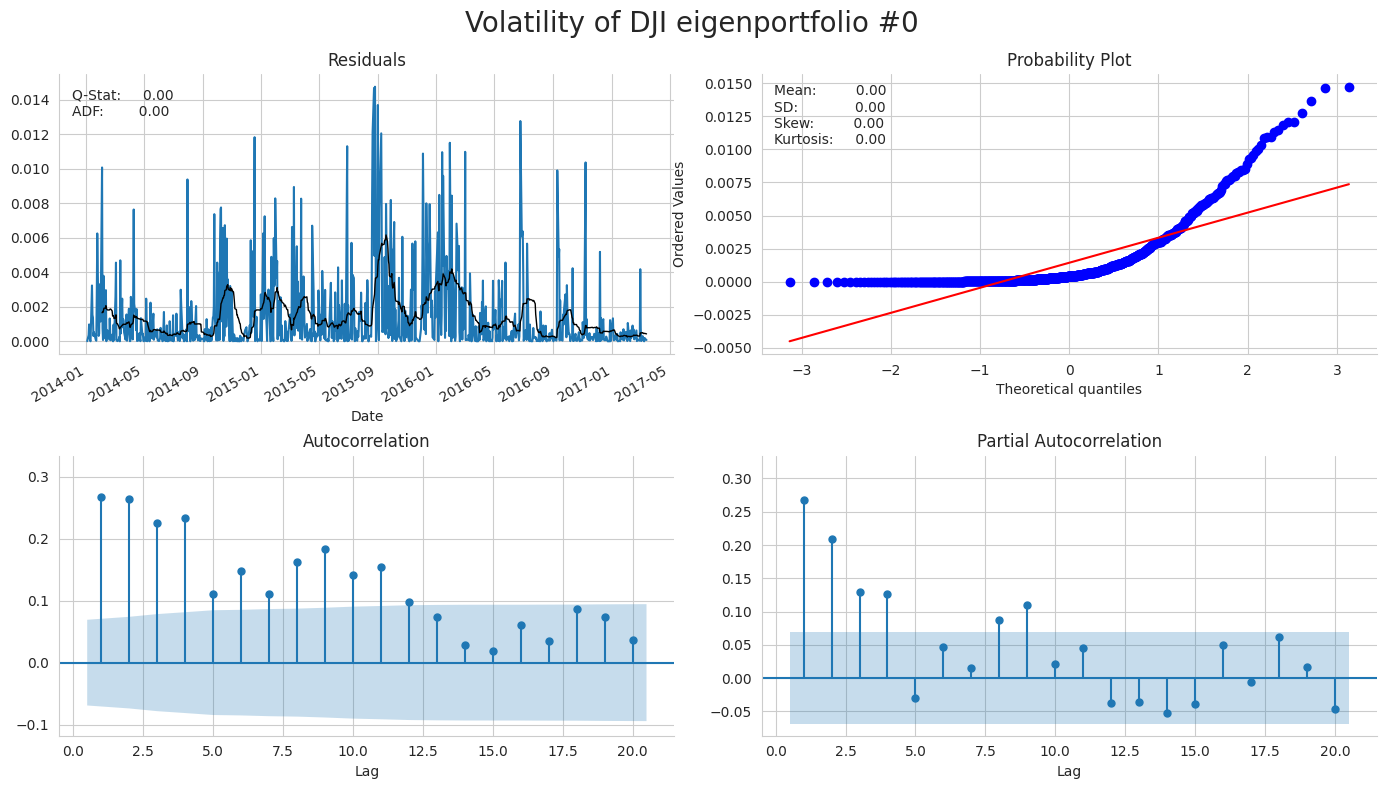

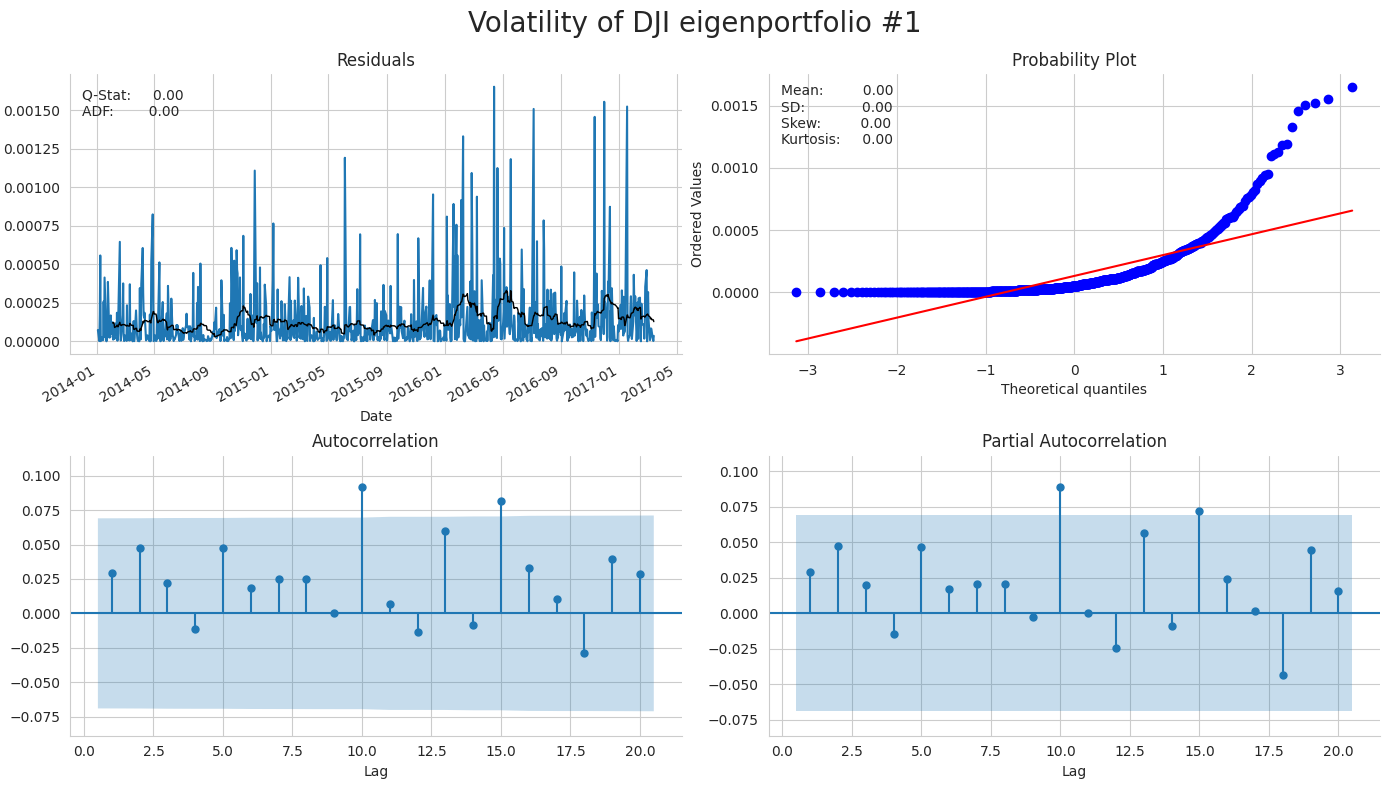

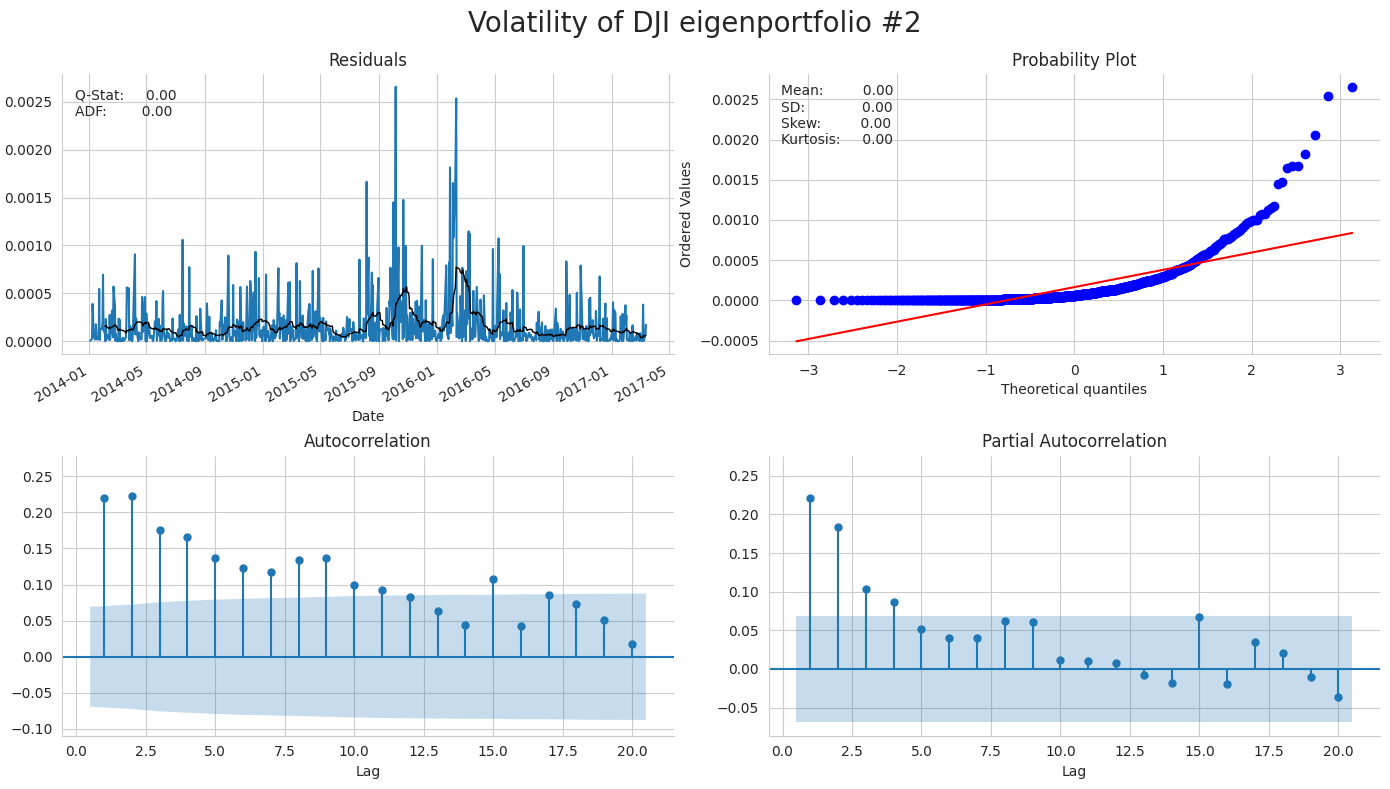

In [ ]:
for i in range(3):
    plot_correlogram((DJI_eport_train[i]-DJI_eport_train[i].mean())**2,
                     lags=20,title=f'Volatility of DJI eigenportfolio #{i}')

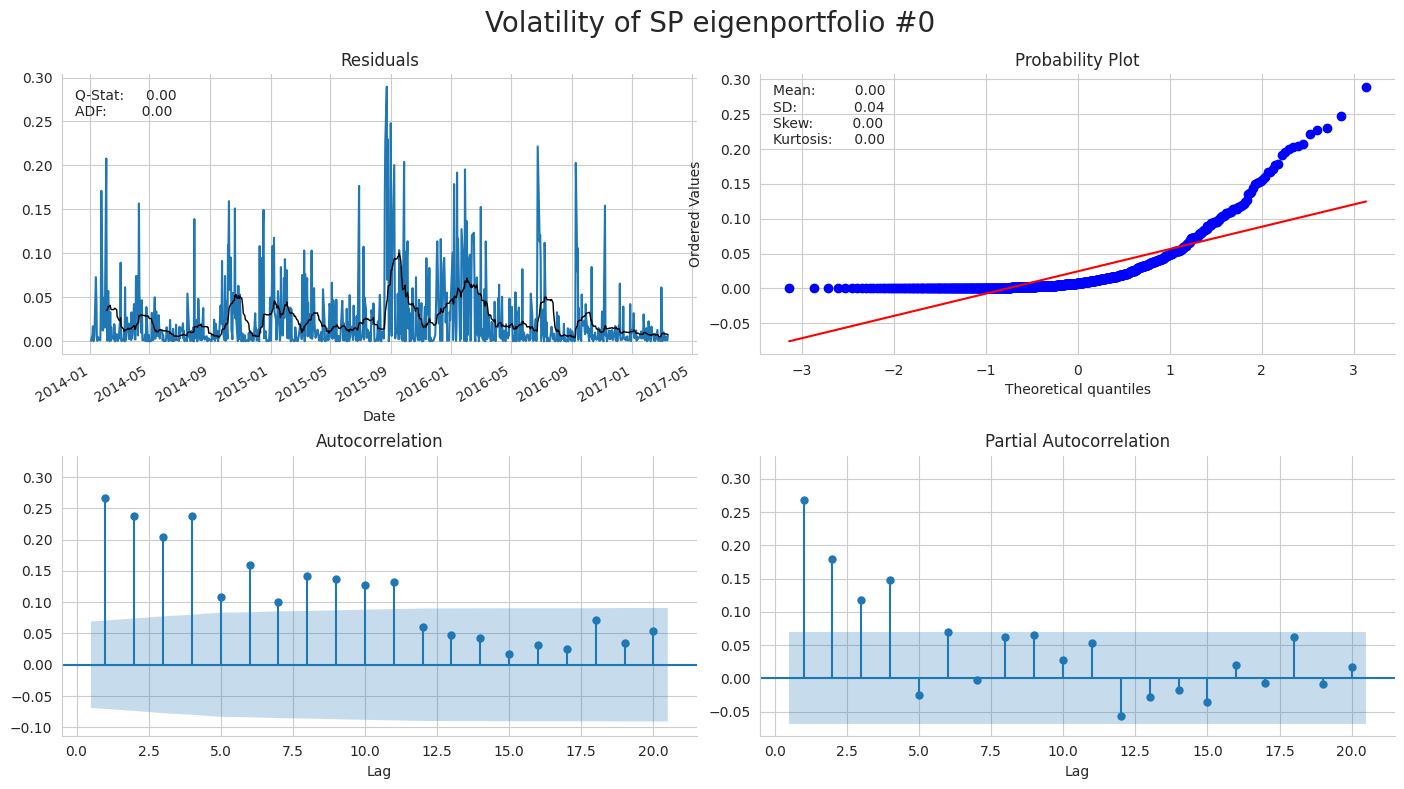

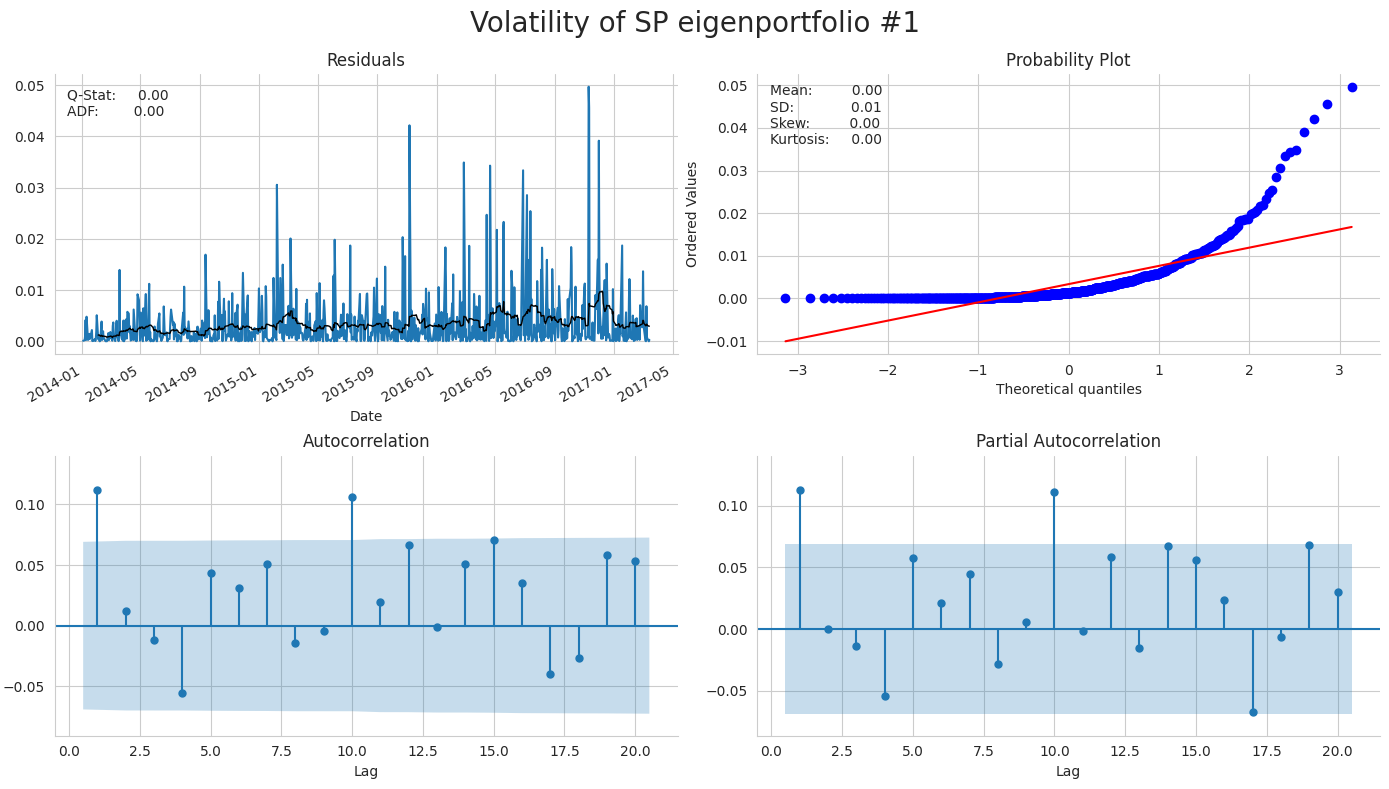

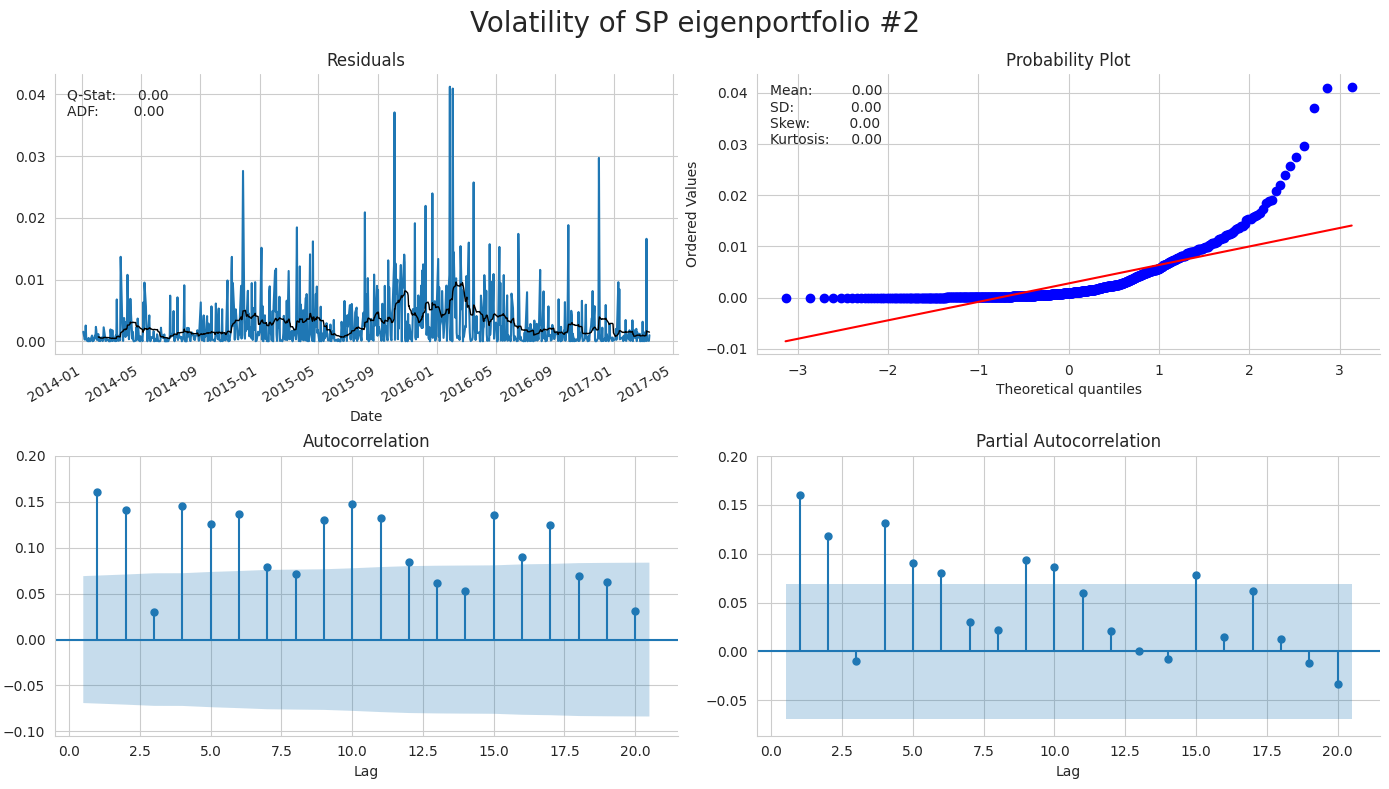

In [ ]:
for i in range(3):
    plot_correlogram((SP_eport_train[i]-SP_eport_train[i].mean())**2,
                     lags=20,title=f'Volatility of SP eigenportfolio #{i}')

In [ ]:
train_size = 500
SP_GARCH_results = {}
time_range = SP_eport_train.shape[0]


for j in range(3):
    SP_portfolio = SP_eport_train[j]
    SP_resid = SP_portfolio - SP_portfolio.mean()

    y_true = SP_resid.iloc[train_size:]

    for p in range(1,7):
        for q in range(7):

            aic, bic = [], []
            rmse = []
            var = []
            print(f'SP portfolio {j}, GARCH order = ({p},{q})')

            convergence_error = stationarity_error = 0
            y_pred = []

            for T in tqdm(range(train_size, time_range)):
                train_set = SP_resid.iloc[T-train_size:T]
                try:
                    model = arch_model(y = train_set,
                                       p = p,
                                       q = q,
                                       dist = 'skewt').fit(disp='off')

                    forecast = model.forecast(horizon=1)
                    mu = forecast.mean.iloc[-1,0]

                    var.append(forecast.variance.iloc[-1,0])
                    rmse.append((y_true[T-train_size]-mu)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)
                    
                    del model

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            SP_GARCH_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(var),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

In [52]:
df_SP_GARCH_results = pd.DataFrame(SP_GARCH_results).T
df_SP_GARCH_results.columns = ['RMSE','var', 'AIC', 'BIC', 'convergence', 'stationarity']
df_SP_GARCH_results.index.names = ['i','p', 'q']


df_SP_GARCH_results.to_csv('./results/df_SP_GARCH_results.csv')

In [58]:
SP_best_GARCH = []


for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(1,7):
        for q in range(7):
            bic_tmp = df_SP_GARCH_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
                
    SP_best_GARCH.append((i,p_best,q_best))

In [59]:
SP_best_GARCH

[(0, 1, 1), (1, 2, 0), (2, 1, 1)]

In [ ]:
train_size = 500
DJI_GARCH_results = {}
time_range = DJI_eport_train.shape[0]


for j in range(3):
    DJI_portfolio = DJI_eport_train[j]
    DJI_resid = DJI_portfolio - DJI_portfolio.mean()

    y_true = DJI_resid.iloc[train_size:]

    for p in range(1,7):
        for q in range(7):

            aic, bic = [], []
            rmse = []
            var = []
            print(f'DJI portfolio {j}, GARCH order = ({p},{q})')

            convergence_error = stationarity_error = 0
            #y_pred = []

            for T in tqdm(range(train_size, time_range)):
                train_set = DJI_resid.iloc[T-train_size:T]
                try:
                    model = arch_model(y = train_set,
                                       p = p,
                                       q = q,
                                       dist = 'skewt').fit(disp='off')

                    forecast = model.forecast(horizon=1)
                    mu = forecast.mean.iloc[-1,0]

                    var.append(forecast.variance.iloc[-1,0])
                    rmse.append((y_true[T-train_size]-mu)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            DJI_GARCH_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(var),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

In [54]:
df_DJI_GARCH_results = pd.DataFrame(DJI_GARCH_results).T
df_DJI_GARCH_results.columns = ['RMSE','var', 'AIC', 'BIC', 'convergence', 'stationarity']
df_DJI_GARCH_results.index.names = ['i','p', 'q']


df_DJI_GARCH_results.to_csv('./results/df_DJI_GARCH_results.csv')

In [ ]:
df_DJI_GARCH_results = pd.read_csv('./results/df_DJI_GARCH_results.csv')

In [60]:
DJI_best_GARCH = []


for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(1,7):
        for q in range(7):
            bic_tmp = df_DJI_GARCH_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
                
    DJI_best_GARCH.append((i,p_best,q_best))

In [61]:
DJI_best_GARCH

[(0, 2, 1), (1, 2, 1), (2, 4, 1)]

In [73]:
df_DJI_GARCH_results.loc[2,6,1]

RMSE            2.273565e+22
var             8.311938e+22
AIC             3.744483e+04
BIC             3.749119e+04
convergence     0.000000e+00
stationarity    0.000000e+00
Name: (2, 6, 1), dtype: float64